In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scienceplots
import math
import json
import torch
from torch.utils.data import DataLoader
import random

In [6]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_16_U_1_number_of_random_initials_10_occupied_128_128/P_HF_result.h5", 'r') as f:
    P = np.transpose(f['P_HF_result_1'][()])

Calculating spin-up density table (nupTab)...
Calculating spin-down density table (ndownTab)...
Calculations complete. Now plotting.


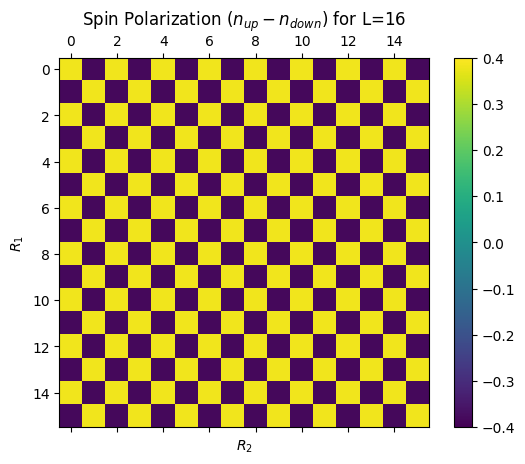

In [7]:
from itertools import product

# Define the index function. Note: Python uses 0-based indexing.
# This function takes 1-based inputs like the Mathematica version
# but returns a 0-based index for use with NumPy arrays.
def index(ik1, ik2, s, L):
    """Maps 1-based (ik1, ik2, s) to a 0-based linear index."""
    return (ik1 - 1) * L * 2 + (ik2 - 1) * 2 + (s - 1)

# Set the lattice size
L = 16


def calculate_nspinpolarized_table(s, P, L):
    """
    Calculates the spin-polarized density table for a given spin 's'.
    This function implements the vectorized version of the Mathematica 'Sum'.
    """
    # 1. Extract the L^2 x L^2 submatrix for the given spin 's' from P.
    k_indices_1_based = list(product(range(1, L + 1), repeat=2))
    
    linear_indices = [index(ik1, ik2, s, L) for ik1, ik2 in k_indices_1_based]
    
    # np.ix_ allows for efficient extraction of submatrices
    P_s = P[np.ix_(linear_indices, linear_indices)]
    
    # 2. Create the Fourier matrix E, where E_kr = exp(i * k . R)
    k_coords = np.arange(L)
    R_coords = np.arange(L)
    
    # Create L^2 k-vectors and R-vectors
    k_grid_x, k_grid_y = np.meshgrid(k_coords, k_coords, indexing='ij')
    R_grid_x, R_grid_y = np.meshgrid(k_coords, k_coords, indexing='ij')

    k_vectors = np.stack([k_grid_x.ravel(), k_grid_y.ravel()], axis=1)
    R_vectors = np.stack([R_grid_x.ravel(), R_grid_y.ravel()], axis=1)

    # Calculate k . R for all combinations
    k_dot_R = np.einsum('bi,ci->bc', k_vectors, R_vectors) # shape: (L^2, L^2)
    
    E = np.exp(1j * 2 * np.pi / L * k_dot_R)

    # 3. Calculate the density n(R,s) using the vectorized formula.
    # n_s = diag(E^H @ P_s^* @ E) / L^2
    # @ is the matrix multiplication operator
    n_table_flat = np.diag(E.conj().T @ P_s.conj() @ E) / (L**2)
    
    # 4. Reshape the flat array of L^2 values into an L x L matrix
    # The result should be real, so we take the real part to discard
    # any small imaginary noise from floating point inaccuracies.
    return n_table_flat.real.reshape(L, L)

# Calculate the spin-up and spin-down density tables
print("Calculating spin-up density table (nupTab)...")
nupTab = calculate_nspinpolarized_table(1, P, L) # s=1 for spin up

print("Calculating spin-down density table (ndownTab)...")
ndownTab = calculate_nspinpolarized_table(2, P, L) # s=2 for spin down

print("Calculations complete. Now plotting.")

# Calculate the difference (magnetization)
magnetization = nupTab - ndownTab

# Plot the result using Matplotlib, which is the equivalent of MatrixPlot
fig, ax = plt.subplots()
im = ax.matshow(magnetization, vmin=-0.4, vmax=0.4)

# Add a color bar, equivalent to PlotLegends -> Automatic
fig.colorbar(im, ax=ax)

ax.set_title(f"Spin Polarization ($n_{{up}} - n_{{down}}$) for L={L}")
ax.set_xlabel("$R_2$")
ax.set_ylabel("$R_1$")

plt.show()

In [24]:
import sys
sys.path.append('/blue/yujiabin/awwab.azam/hartree-fock-code/src')
from jobs.tMoTe2_6x6_9x9_trans_breaking_july23.utils import (
    HF_SimpleModel,
    HF_3x3_Dataset,
    get_normalization_constants_3x3,
    denormalize
)

In [2]:
plt.style.use(['science', 'notebook', 'grid'])

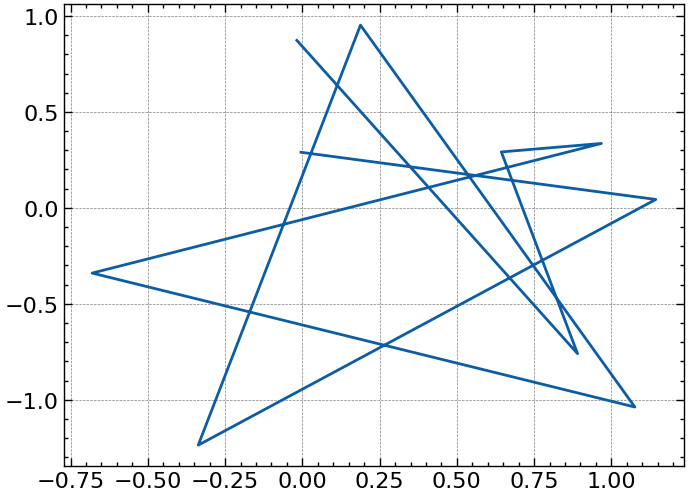

In [3]:
# just testing if Python stuff is working properly
x = np.random.randn(10)
y = np.random.randn(10)
plt.plot(x, y)
plt.show()

### Energy Visualization

(4014,)


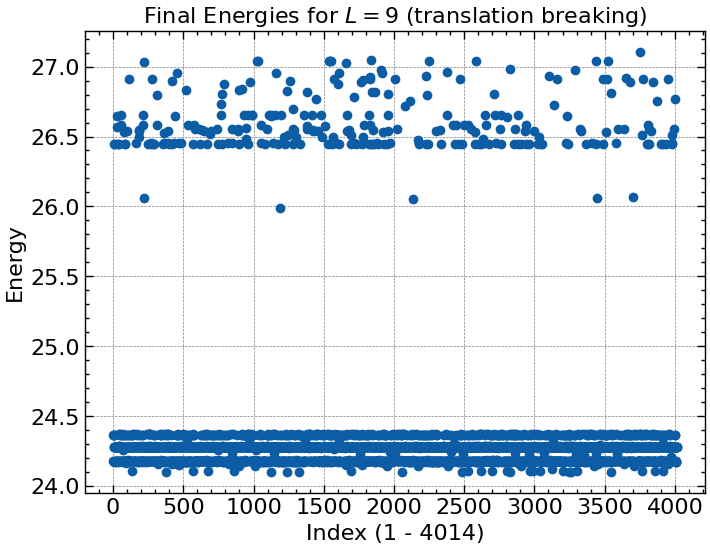

In [12]:
energy_list = []

L = 9
num_folders = 72

for i in range(1, num_folders + 1):
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/L_{L}/data/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_{L}_index_{i}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 201):
            try:
                energy_list.append(f[str(initial)]['E_tot_per_unit_cell'][()])
            except:
                continue

energy_list = np.array(energy_list)
print(energy_list.shape)

indices = np.array(list(range(1, len(energy_list) + 1)))

plt.scatter(indices, energy_list.real)
plt.xlabel(f"Index (1 - {len(energy_list)})")
plt.ylabel("Energy")
plt.title(f"Final Energies for $L={L}$ (translation breaking)")
plt.show()

In [13]:
print(len(energy_list[energy_list.real - np.min(energy_list.real) < 1e-4]))
print(len(energy_list[energy_list.real - np.min(energy_list.real) < 1e-3]))
print(len(energy_list[energy_list.real - np.min(energy_list.real) < 1e-2]))
print(len(energy_list[energy_list.real - np.min(energy_list.real) < 1e-1]))

1
23
28
1300


In [14]:
min_energy = np.min(energy_list.real)
print(f"Trans-breaking min energy: {min_energy}")

Trans-breaking min energy: 24.10058958943192


In [19]:
trans_invariant_energy_list = []

for i in range(1, 51):
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_old/tMoTe2_L_6/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_index_{i}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 201):
            trans_invariant_energy_list.append(f[str(initial)]['Enext'][()])

trans_invariant_energy_list = np.array(trans_invariant_energy_list)
print(trans_invariant_energy_list.shape)

indices = np.array(list(range(1, 10_001)))

print(f"Trans-invariant min energy: {np.min(trans_invariant_energy_list.real) / 36}")

(10000,)
Trans-invariant min energy: 87.36662424228125


In [39]:
print(trans_invariant_energy_list[0])

(3145.198513048199+1.7334827992664438e-14j)


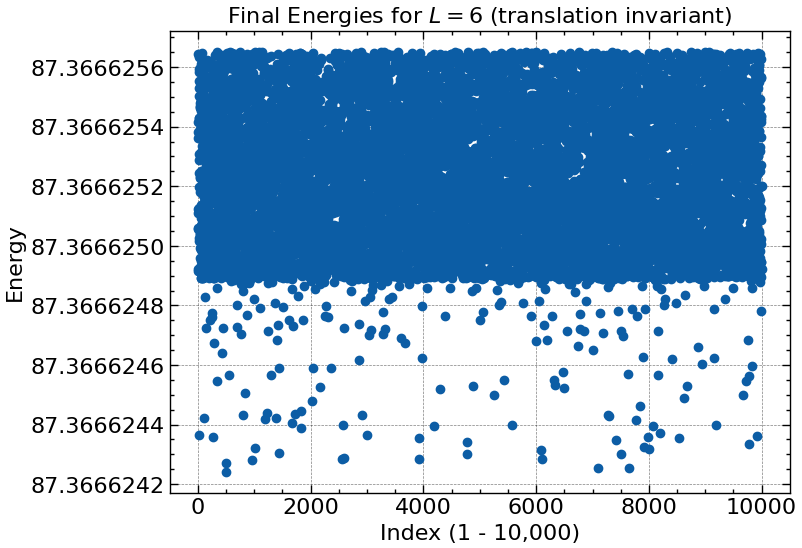

In [16]:
plt.scatter(indices, trans_invariant_energy_list.real / 36)
plt.xlabel("Index (1 - 10,000)")
plt.ylabel("Energy")
plt.title("Final Energies for $L=6$ (translation invariant)")
plt.ticklabel_format(axis='y', style='plain', useOffset=False)
plt.show()

In [21]:
second_min_energy = np.min(energy_list[energy_list.real > 52.09529382366128].real)
print(f"2nd lowest energy: {second_min_energy}")

2nd lowest energy: 52.134551400696395


### Data Analysis

In [15]:
lowest_energy_matrix = np.zeros((4*(L**2), 4*(L**2)), dtype=np.complex128)
for i in range(1, num_folders):
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/L_{9}/data/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_{9}_index_{i}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 201):
            try:
                energy = f[str(initial)]['E_tot_per_unit_cell'][()]
                if energy.real == min_energy:
                    lowest_energy_matrix = np.transpose(f[str(initial)]['OP_mat'][()])
            except:
                continue

In [21]:
# first find the lowest energy matrix
new_energy_list = []
with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/Unrestricted_HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6/HF_results_data.h5", 'r') as f:
    for initial in range(1, 11):
        new_energy_list.append(f[str(initial)]['E_tot_per_unit_cell'][()])
    new_energy_list = np.array(new_energy_list)
    idx = np.argmin(new_energy_list.real) + 1
    lowest_energy_matrix = np.transpose(f[str(idx)]['OP_mat'][()])

# Find the global min and max for the color scale ---
C_MIN_REAL_BREAKING = np.min(lowest_energy_matrix.real)
C_MAX_REAL_BREAKING = np.max(lowest_energy_matrix.real)
C_MIN_IMAG_BREAKING = np.min(lowest_energy_matrix.imag)
C_MAX_IMAG_BREAKING = np.max(lowest_energy_matrix.imag)

print(C_MIN_REAL_BREAKING)
print(C_MAX_REAL_BREAKING)
print(C_MIN_IMAG_BREAKING)
print(C_MAX_REAL_BREAKING)

-0.08890473513580889
0.5968144569503868
-0.1560211964493936
0.5968144569503868


In [ ]:
C_MIN_REAL_BREAKING=-1.0  # -0.08890473513580889
C_MAX_REAL_BREAKING=1.0   # 0.5968144569503868
C_MIN_IMAG_BREAKING=-1.0  # -0.1560211964493936
C_MAX_IMAG_BREAKING=1.0   # 0.5968144569503868

In [4]:
def plot_complex_matrix(matrix, title):
    """
    Plots a complex-valued matrix. The real part is shown in one subplot,
    and the imaginary part is shown in another subplot.

    Args:
        matrix (torch.Tensor or np.ndarray): Complex-valued matrix to plot.
    """
    if isinstance(matrix, np.ndarray):
        real_part = matrix.real
        imag_part = matrix.imag
    else:
        raise TypeError("Input must be a PyTorch tensor or a NumPy array.")

    plt.figure(figsize=(20, 10))

    # Plot the real part
    plt.subplot(1, 2, 1)
    plt.imshow(real_part, cmap='RdBu', interpolation='none', vmin=C_MIN_REAL_BREAKING, vmax=C_MAX_REAL_BREAKING)
    plt.colorbar()
    plt.title(f"Re of {title}")

    # Plot the imaginary part
    plt.subplot(1, 2, 2)
    plt.imshow(imag_part, cmap='BrBG', interpolation='none', vmin=C_MIN_IMAG_BREAKING, vmax=C_MAX_IMAG_BREAKING)
    plt.colorbar()
    plt.title(f"Im of {title}")

    plt.tight_layout()
    plt.show()

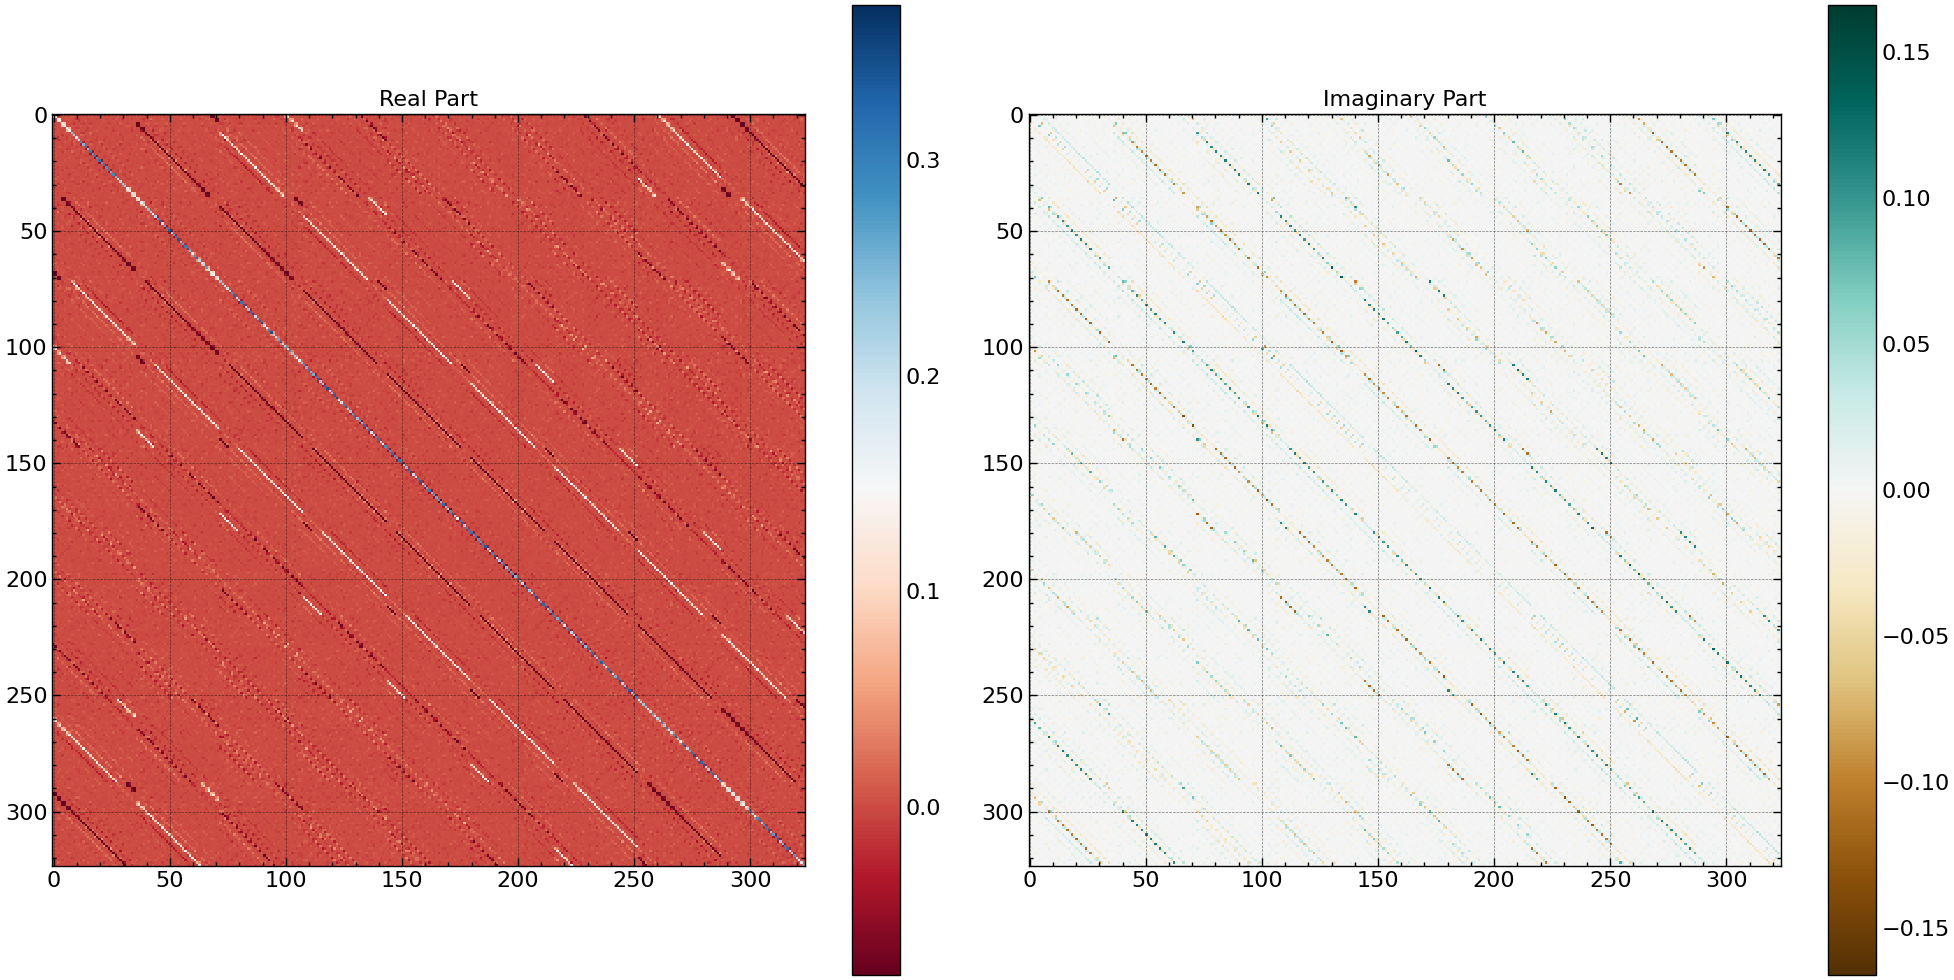

In [16]:
plot_complex_matrix(lowest_energy_matrix)

In [ ]:
for L in [8, 16]:
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_{L}_U_1_number_of_random_initials_10_occupied_{int(L**2/2)}_{int(L**2/2)}/P_HF_result.h5", 'r') as f:
        new_energy_list = []
        for initial in range(1, 11):
            new_energy_list.append(f[f'gap_{initial}'][()])

    new_energy_list = np.array(new_energy_list)

    indices = np.array(list(range(1, 11)))

    # print(f"min energy: {np.min(new_energy_list.real)}")

    plt.scatter(indices, new_energy_list.real)
    plt.xlabel("Index (1 - 10)")
    plt.ylabel("Gap")
    plt.title(f"Hubbard model Final Gaps for $L={L}$")
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

In [ ]:
L = 6
energy_list = []
num_folders = 50

for i in range(1, num_folders + 1):
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/L_{L}/data/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_{L}_index_{i}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 201):
            try:
                energy_list.append(f[str(initial)]['E_tot_per_unit_cell'][()])
            except:
                continue

energy_list = np.array(energy_list)
print(energy_list.shape)

min_energy = np.min(energy_list.real)
print(f"Trans-breaking min energy: {min_energy}")

lowest_energy_matrix = np.zeros((4*(L**2), 4*(L**2)), dtype=np.complex128)
for i in range(1, num_folders + 1):
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/L_{L}/data/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_{L}_index_{i}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 201):
            try:
                energy = f[str(initial)]['E_tot_per_unit_cell'][()]
                if energy.real == min_energy:
                    lowest_energy_matrix = np.transpose(f[str(initial)]['OP_mat'][()])
            except:
                continue

# Find the global min and max for the color scale ---
C_MIN_REAL_BREAKING = np.min(lowest_energy_matrix.real)
C_MAX_REAL_BREAKING = np.max(lowest_energy_matrix.real)
C_MIN_IMAG_BREAKING = np.min(lowest_energy_matrix.imag)
C_MAX_IMAG_BREAKING = np.max(lowest_energy_matrix.imag)

lowest_energy_band = energy_list[energy_list.real - np.min(energy_list.real) < 1e-1]

In [ ]:
# Generate a list of 10 random integers within the specified range
random_integers = [random.randint(0, len(lowest_energy_band) - 1) for _ in range(10)]

# Print the generated list
print(random_integers)

for j in random_integers:
    specific_energy = lowest_energy_band[j].real
    for i in range(1, num_folders):
        with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/L_{L}/data/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_{L}_index_{i}/HF_results_data.h5", 'r') as f:
            for initial in range(1, 201):
                try:
                    energy = f[str(initial)]['E_tot_per_unit_cell'][()]
                    if energy.real == specific_energy:
                        plot_complex_matrix(np.transpose(f[str(initial)]['OP_mat'][()]))
                except:
                    continue


In [60]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/L_6/data/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_index_1/HF_results_data.h5", 'r') as f:
    print(f['1'].keys())

<KeysViewHDF5 ['E_tot_per_unit_cell', 'OP_mat', 'gap']>


In [ ]:
for dist in [50, 30, 15, 10, 2, 0.1]:

    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/Unrestricted_HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_gate_to_gate_dist_{dist}/HF_results_data.h5", 'r') as f:
        gap_list = []
        for initial in range(1, 11):
            gap_list.append(f[str(initial)]['gap'][()])  # for invariant, use Enext, divide by L^2=36

    gap_list = np.array(gap_list)

    indices = np.array(list(range(1, 11)))

    plt.scatter(indices, gap_list.real)
    plt.xlabel("Index (1 - 10)")
    plt.ylabel("Gap")
    plt.title(f"Final Gaps for $L=6$ with gate_to_gate_distance={dist}")
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

In [ ]:
for dist in [50, 30, 15, 10, 2, 0.1]:

    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_gate_to_gate_dist_{dist}/HF_results_data.h5", 'r') as f:
        new_energy_list = []
        for initial in range(1, 11):
            new_energy_list.append(f[str(initial)]['Enext'][()] / 36)  # for invariant, use Enext, divide by L^2=36

    new_energy_list = np.array(new_energy_list)

    indices = np.array(list(range(1, 11)))

    print(f"min energy for {dist}: {np.min(new_energy_list.real)}")

    plt.scatter(indices, new_energy_list.real)
    plt.xlabel("Index (1 - 10)")
    plt.ylabel("Energy")
    plt.title(f"Trans-invariant Final Energies for $L=6$, gate_to_gate_distance={dist}")
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

In [ ]:
with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/Unrestricted_HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_gate_to_gate_dist_0.1/HF_results_data.h5", 'r') as f:
        for initial in range(1, 11):
                plot_complex_matrix(np.transpose(f[str(initial)]['OP_mat'][()]))

In [6]:
def sort_coordinates_to_matrix_indices(coords, atol=1e-2):
    """
    Given a (n, 2) array of (x, y) coordinates that approximately lie on a grid,
    return an (n, 2) array of (i, j) indices representing matrix row and column
    indices based on spatial location.

    Parameters:
        coords : np.ndarray
            Array of shape (n, 2) containing x, y coordinates.
        atol : float
            Tolerance for grouping coordinates into grid lines.

    Returns:
        indices : np.ndarray
            Array of shape (n, 2) containing integer grid indices.
    """
    coords = np.asarray(coords)
    x_vals = coords[:, 0]
    y_vals = coords[:, 1]

    # Cluster the x and y coordinates by rounding within tolerance
    unique_x = np.unique(np.round(x_vals / atol) * atol)
    unique_y = np.unique(np.round(y_vals / atol) * atol)

    # Sort the grid lines (to assign index 0 to smallest coordinate)
    sorted_x = np.sort(unique_x)
    sorted_y = np.sort(unique_y)

    # Create a mapping from real x/y value to discrete index
    def find_index(val, sorted_vals):
        idx = np.argmin(np.abs(sorted_vals - val))
        return idx

    matrix_indices = np.empty_like(coords, dtype=int)
    for i, (x, y) in enumerate(coords):
        col_idx = find_index(x, sorted_x)
        row_idx = find_index(y, sorted_y)
        matrix_indices[i] = [row_idx, col_idx]

    return matrix_indices

In [27]:
# get 4x4 across diagonal
diagonal_tensor = np.zeros((6, 6, 4, 4), dtype=np.complex128)
V = np.zeros((6, 6, 2))
for k_1 in range(0, 6):
    for k_2 in range(0, 6):
        matrix_4x4 = lowest_energy_matrix[(k_1*4*6 + k_2*4) : (k_1*4*6 + k_2*4) + 4, (k_1*4*6 + k_2*4) : (k_1*4*6 + k_2*4) + 4]
        diagonal_tensor[k_1, k_2, :, :] = matrix_4x4

        v_1 = k_1 / 6
        v_2 = k_2 / 6
        V[k_1, k_2, :] = np.array([v_1, v_2])

In [13]:
# Find the global min and max for the color scale ---
C_MIN_REAL = np.inf
C_MAX_REAL = -np.inf
C_MIN_IMAG = np.inf
C_MAX_IMAG = -np.inf

# get the color bounds
for dist in [50, 30, 15, 10, 2, 0.1]:
    # first find the lowest energy matrix
    new_energy_list = []
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_gate_to_gate_dist_{dist}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 11):
            new_energy_list.append(f[str(initial)]['Enext'][()].real / 36)
        new_energy_list = np.array(new_energy_list)
        idx = np.argmin(new_energy_list) + 1
        OP = np.transpose(f[str(idx)]['OP_list'][()])

        if np.min(OP.real) < C_MIN_REAL:
            C_MIN_REAL = np.min(OP.real)
        if np.max(OP.real) > C_MAX_REAL:
            C_MAX_REAL = np.max(OP.real)
        if np.min(OP.imag) < C_MIN_IMAG:
            C_MIN_IMAG = np.min(OP.imag)
        if np.max(OP.imag) > C_MAX_IMAG:
            C_MAX_IMAG = np.max(OP.imag)

In [5]:
C_MIN_REAL = -1.0
C_MAX_REAL = 1.0
C_MIN_IMAG = -1.0
C_MAX_IMAG = 1.0

In [ ]:
# code for translation-invariant case
for dist in [50, 30, 15, 10, 2, 0.1]:
    # first find the lowest energy matrix
    new_energy_list = []
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_gate_to_gate_dist_{dist}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 11):
            new_energy_list.append(f[str(initial)]['Enext'][()].real / 36)
        new_energy_list = np.array(new_energy_list)
        idx = np.argmin(new_energy_list) + 1
        OP_list = np.transpose(f[str(idx)]['OP_list'][()])
    

    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/Set_up_folder_L_6_valley_1_gate_to_gate_dist_{dist}/SP_MkqTab_IntHartree_IntFock_data.h5", "r") as f:
        BZindex = np.transpose(f['BZindex'][()])
        L_square = BZindex.shape[0]
        L = int(round(math.sqrt(L_square)))
        print(f"L is {L}")
        print(BZindex.shape)
    coordinate_mapping = sort_coordinates_to_matrix_indices(BZindex)

    # get positions
    V = np.zeros((L, L, 2))
    for i in range(L):
        for j in range(L):
            for k in range(L ** 2):
                i_new = coordinate_mapping[k][0]
                j_new = coordinate_mapping[k][1]
                if (i == i_new) and (j == j_new):
                    V[i, j, 0] = BZindex[k, 0]
                    V[i, j, 1] = BZindex[k, 1]
    X = V[:, :, 0]
    Y = V[:, :, 1]

    m_dim = 2

    # start plotting
    figure, axes = plt.subplots(m_dim, m_dim, figsize=(12, 12))

    # We will store the last scatter plot in a variable to use for the colorbar
    scatter = None

    # iterate over the 4x4 matrix
    for row in range(m_dim):
        for col in range(m_dim):
            # first find the LxL matrix
            matrix = np.zeros((L, L))
            for i in range(L):
                for j in range(L):
                    for k in range(L ** 2):
                        i_new = coordinate_mapping[k][0]
                        j_new = coordinate_mapping[k][1]
                        if (i == i_new) and (j == j_new):
                            matrix[i, j] = OP_list[k, row, col].real

            # now make the scatterplot
            ax = axes[row][col]
            ax.set_title(rf"$Re({row+1}, {col+1})^{{\text{{th}}}}$")
            # --- Modified: Use vmin and vmax, and store the scatter object ---
            scatter = ax.scatter(X, Y, c=matrix, cmap="plasma", vmin=C_MIN_REAL, vmax=C_MAX_REAL)
            ax.set_aspect('equal')
            ax.set_facecolor('w')

    # general settings for the whole figure
    figure.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the colorbar
    figure.suptitle(f'Re of trans-invariant OP against $V$, gate_to_gate_distance={dist}', y=1.03, fontsize=25)

    # --- New: Create a single colorbar for the entire figure ---
    # Create a new axes for the colorbar on the right side of the figure
    cbar_ax = figure.add_axes([0.92, 0.15, 0.03, 0.7]) # [left, bottom, width, height]
    figure.colorbar(scatter, cax=cbar_ax)

    # Show plot
    plt.show()


    # start plotting
    figure, axes = plt.subplots(m_dim, m_dim, figsize=(12, 12))

    # We will store the last scatter plot in a variable to use for the colorbar
    scatter = None

    # iterate over the 4x4 matrix
    for row in range(m_dim):
        for col in range(m_dim):
            # first find the LxL matrix
            matrix = np.zeros((L, L))
            for i in range(L):
                for j in range(L):
                    for k in range(L ** 2):
                        i_new = coordinate_mapping[k][0]
                        j_new = coordinate_mapping[k][1]
                        if (i == i_new) and (j == j_new):
                            matrix[i, j] = OP_list[k, row, col].imag

            # now make the scatterplot
            ax = axes[row][col]
            ax.set_title(rf"$Im({row+1}, {col+1})^{{\text{{th}}}}$")
            # --- Modified: Use vmin and vmax, and store the scatter object ---
            scatter = ax.scatter(X, Y, c=matrix, cmap="plasma", vmin=C_MIN_IMAG, vmax=C_MAX_IMAG)
            ax.set_aspect('equal')
            ax.set_facecolor('w')

    # general settings for the whole figure
    figure.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the colorbar
    figure.suptitle(f'Im of trans-invariant OP against $V$, gate_to_gate_distance={dist}', y=1.03, fontsize=25)

    # --- New: Create a single colorbar for the entire figure ---
    # Create a new axes for the colorbar on the right side of the figure
    cbar_ax = figure.add_axes([0.92, 0.15, 0.03, 0.7]) # [left, bottom, width, height]
    figure.colorbar(scatter, cax=cbar_ax)

    # Show plot
    plt.show()

In [23]:
def plot_diagonal_blocks(diagonal_tensor, V, title):
    
    # get limits for the colorbar
    # c_min_real = np.min(diagonal_tensor.real)
    # c_max_real = np.max(diagonal_tensor.real)
    # c_min_imag = np.min(diagonal_tensor.imag)
    # c_max_imag = np.max(diagonal_tensor.imag)
    c_min_real=C_MIN_REAL
    c_max_real=C_MAX_REAL
    c_min_imag=C_MIN_IMAG
    c_max_imag=C_MAX_IMAG

    # get positions
    X = V[:, :, 0]
    Y = V[:, :, 1]

    m_dim = 2

    # start plotting
    figure, axes = plt.subplots(m_dim, m_dim, figsize=(12, 12))

    # We will store the last scatter plot in a variable to use for the colorbar
    scatter = None

    # iterate over the 4x4 matrix
    for row in range(m_dim):
        for col in range(m_dim):
            # first find the 18x18 matrix
            matrix_6x6 = diagonal_tensor[:, :, row, col].real

            # now make the scatterplot
            ax = axes[row][col]
            ax.set_title(rf"$Re({row+1}, {col+1})^{{\text{{th}}}}$")
            # --- Modified: Use vmin and vmax, and store the scatter object ---
            scatter = ax.scatter(X, Y, c=matrix_6x6, cmap="plasma", vmin=c_min_real, vmax=c_max_real)
            ax.set_aspect('equal')
            ax.set_facecolor('w')

    # general settings for the whole figure
    figure.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the colorbar
    figure.suptitle(f'Re of trans-breaking OP against $V$ for {title}', y=1.03, fontsize=25)

    # --- New: Create a single colorbar for the entire figure ---
    # Create a new axes for the colorbar on the right side of the figure
    cbar_ax = figure.add_axes([0.92, 0.15, 0.03, 0.7]) # [left, bottom, width, height]
    figure.colorbar(scatter, cax=cbar_ax)

    # Show plot
    plt.show()


    # start plotting
    figure, axes = plt.subplots(m_dim, m_dim, figsize=(12, 12))

    # We will store the last scatter plot in a variable to use for the colorbar
    scatter = None

    # iterate over the 4x4 matrix
    for row in range(m_dim):
        for col in range(m_dim):
            # first find the 18x18 matrix
            matrix_6x6 = diagonal_tensor[:, :, row, col].imag

            # now make the scatterplot
            ax = axes[row][col]
            ax.set_title(rf"$Im({row+1}, {col+1})^{{\text{{th}}}}$")
            # --- Modified: Use vmin and vmax, and store the scatter object ---
            scatter = ax.scatter(X, Y, c=matrix_6x6, cmap="plasma", vmin=c_min_imag, vmax=c_max_imag)
            ax.set_aspect('equal')
            ax.set_facecolor('w')

    # general settings for the whole figure
    figure.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the colorbar
    figure.suptitle(f'Im of trans-breaking OP against $V$ for {title}', y=1.03, fontsize=25)

    # --- New: Create a single colorbar for the entire figure ---
    # Create a new axes for the colorbar on the right side of the figure
    cbar_ax = figure.add_axes([0.92, 0.15, 0.03, 0.7]) # [left, bottom, width, height]
    figure.colorbar(scatter, cax=cbar_ax)

    # Show plot
    plt.show()

In [ ]:
plot_diagonal_blocks(diagonal_tensor, V)

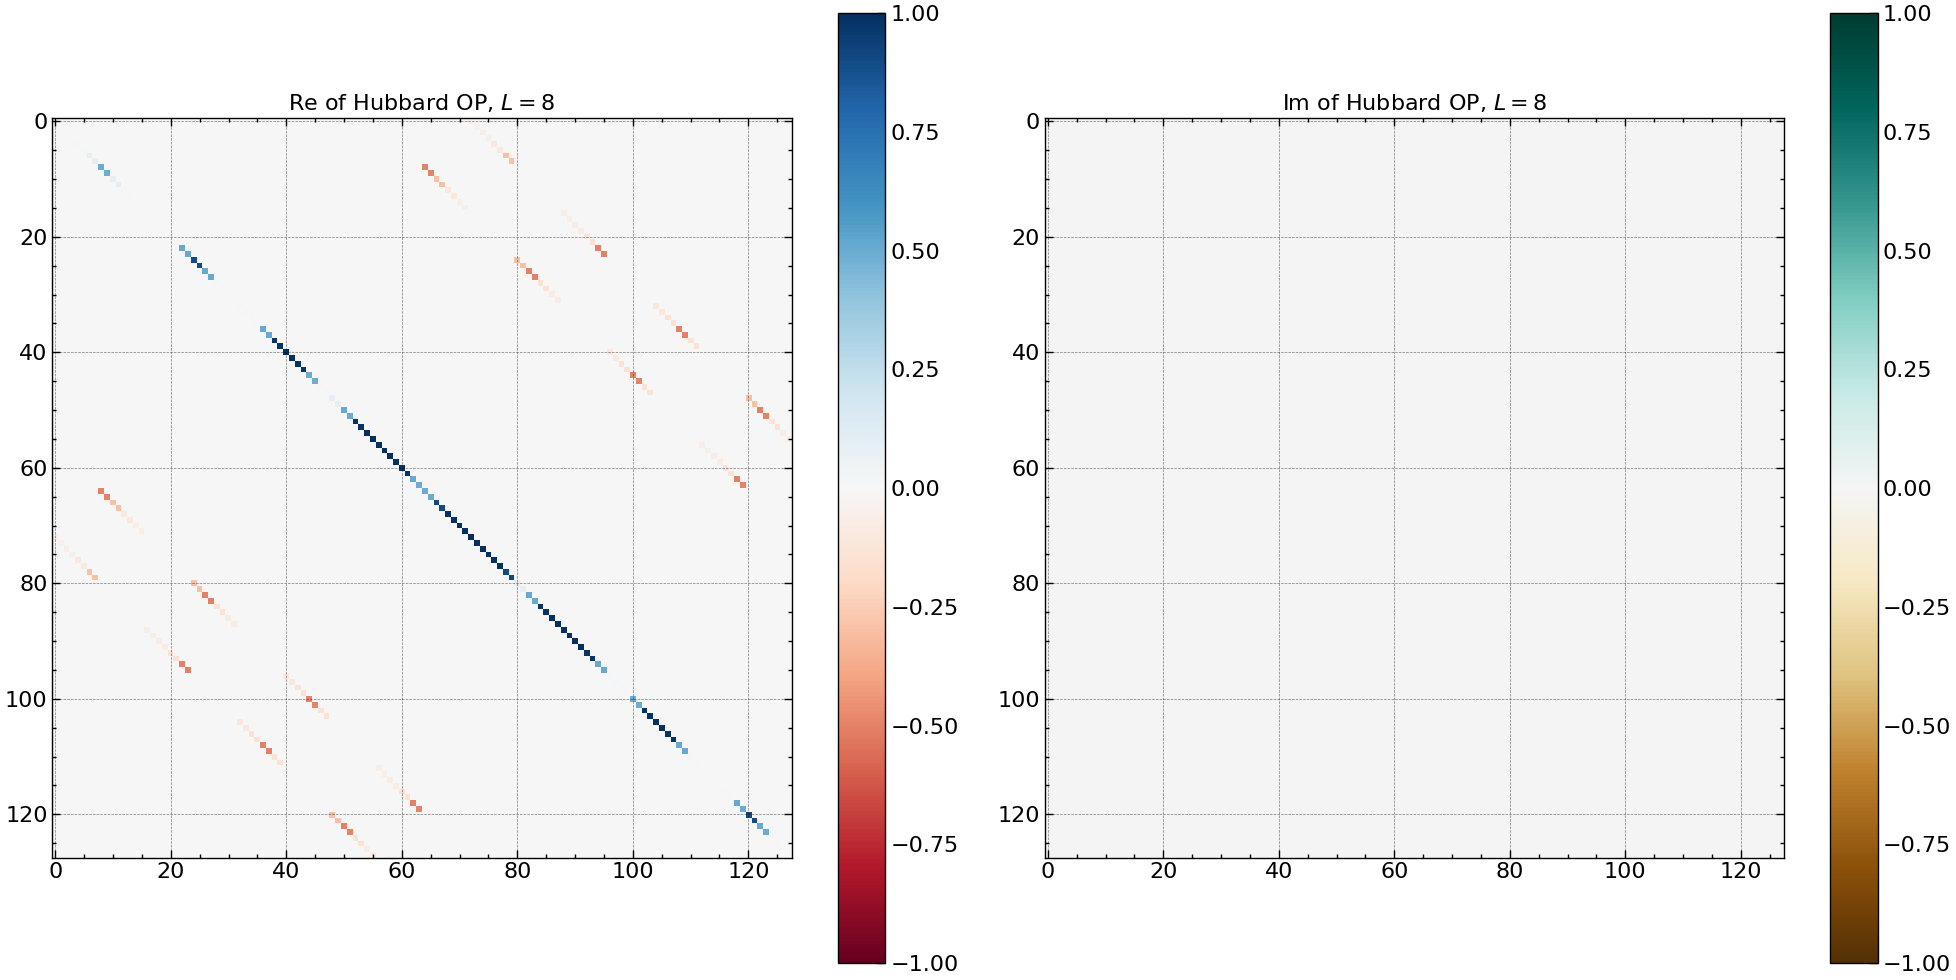

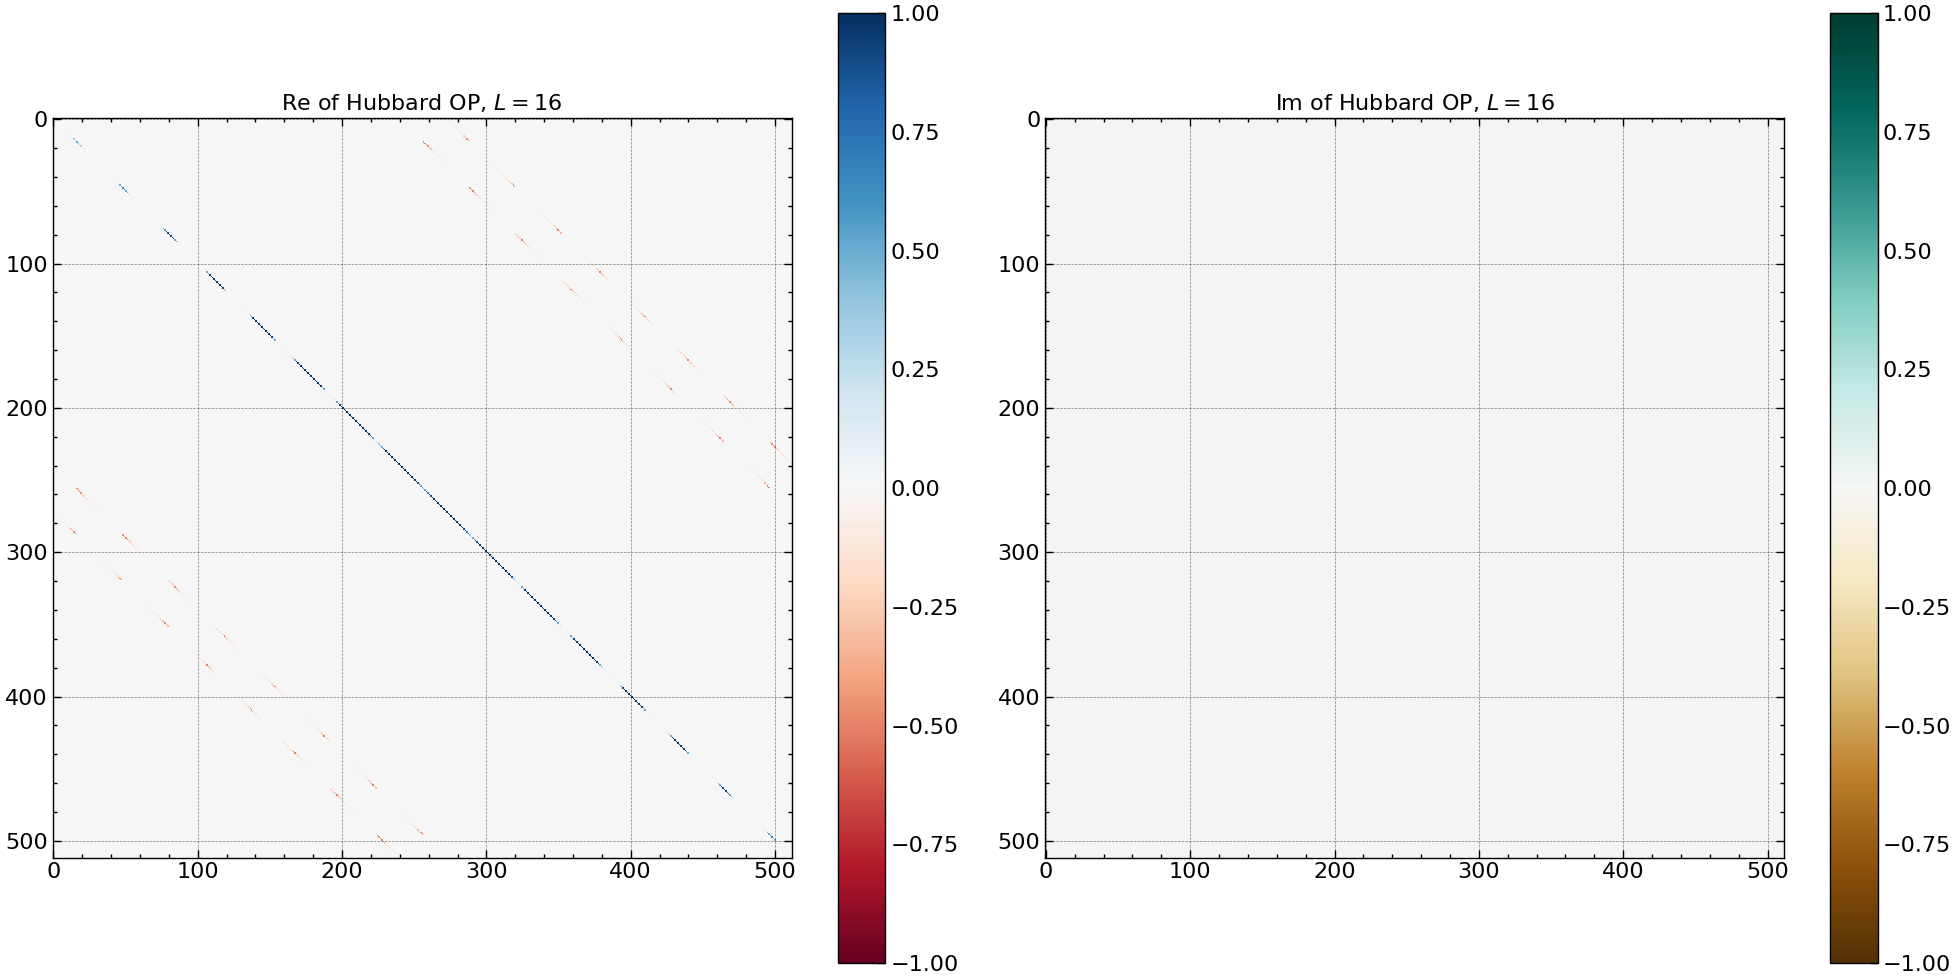

In [51]:
for L in [8, 16]:
    # first find the lowest energy matrix
    new_energy_list = []
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_{L}_U_1_number_of_random_initials_10_occupied_{int(L**2 / 2)}_{int(L**2 / 2)}/P_HF_result.h5", 'r') as f:
        for initial in range(1, 11):
            new_energy_list.append(f[f'HF_energy_per_unit_cell_{initial}'][()])
        new_energy_list = np.array(new_energy_list)
        idx = np.argmin(new_energy_list.real) + 1
        OP = np.transpose(f[f'P_HF_result_{idx}'][()].conj())
    
    plot_complex_matrix(OP, f"Hubbard OP, $L={L}$")

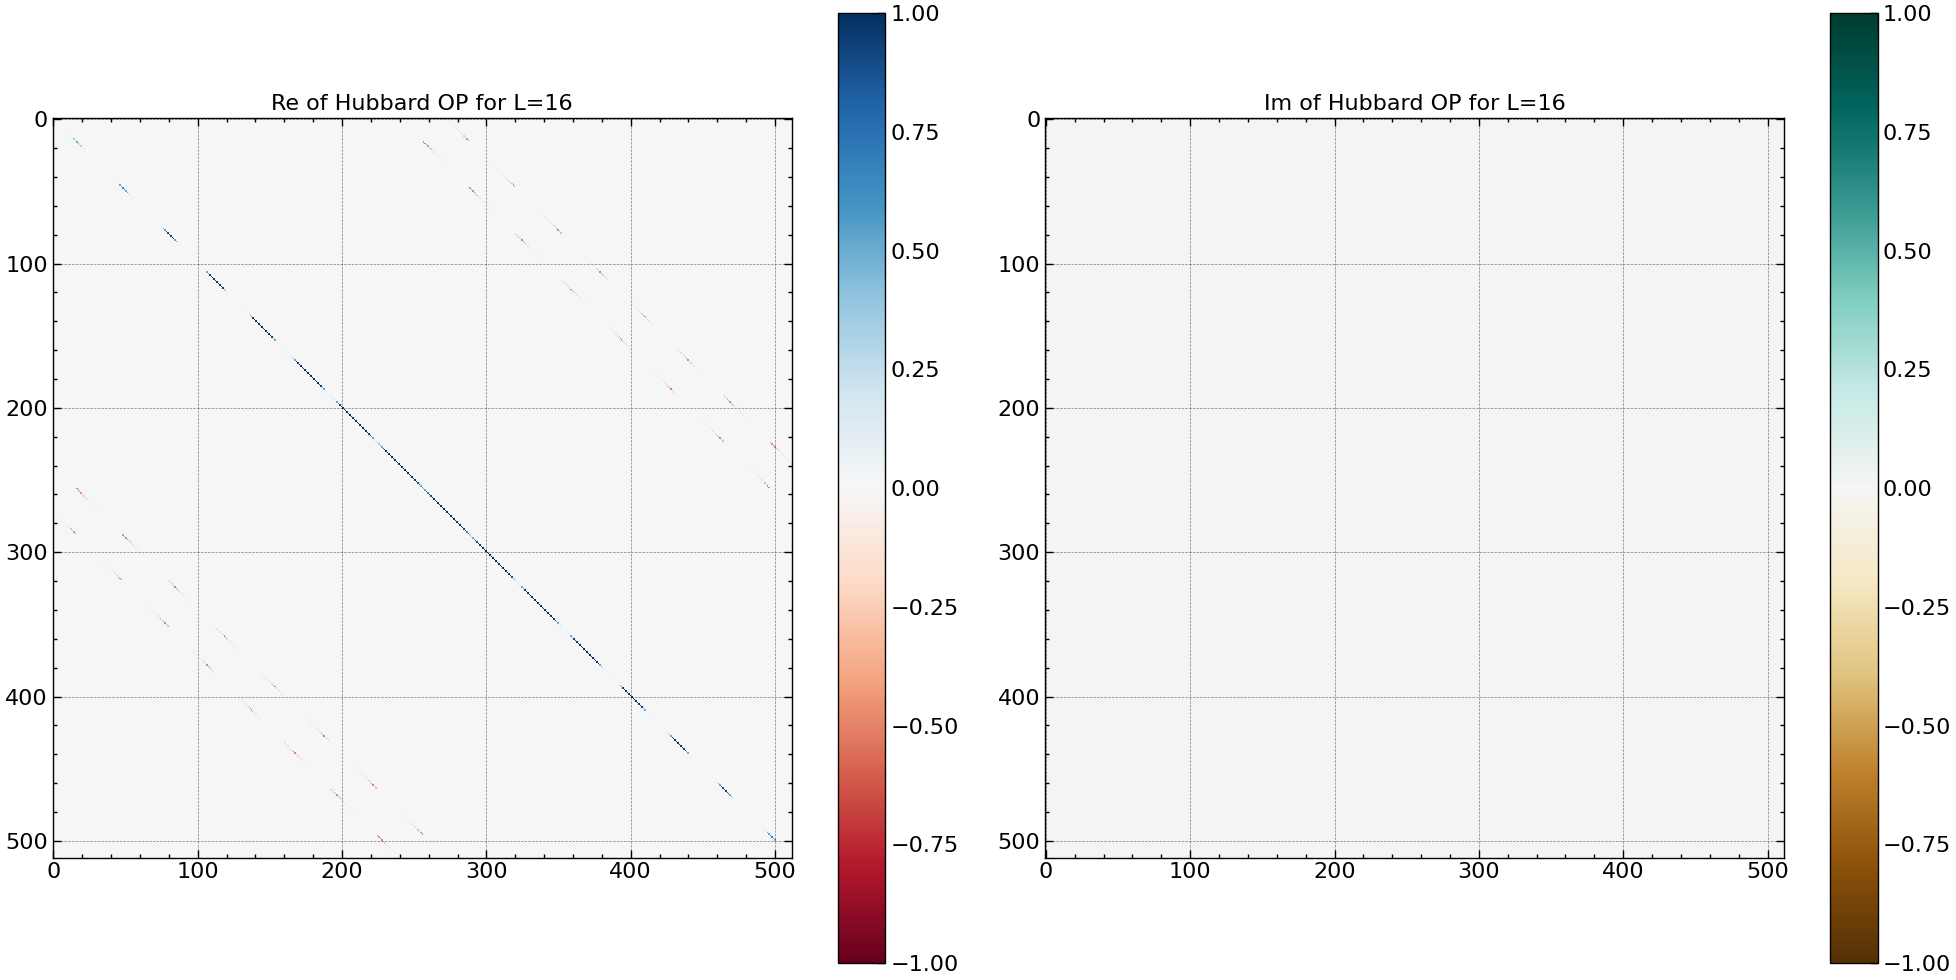

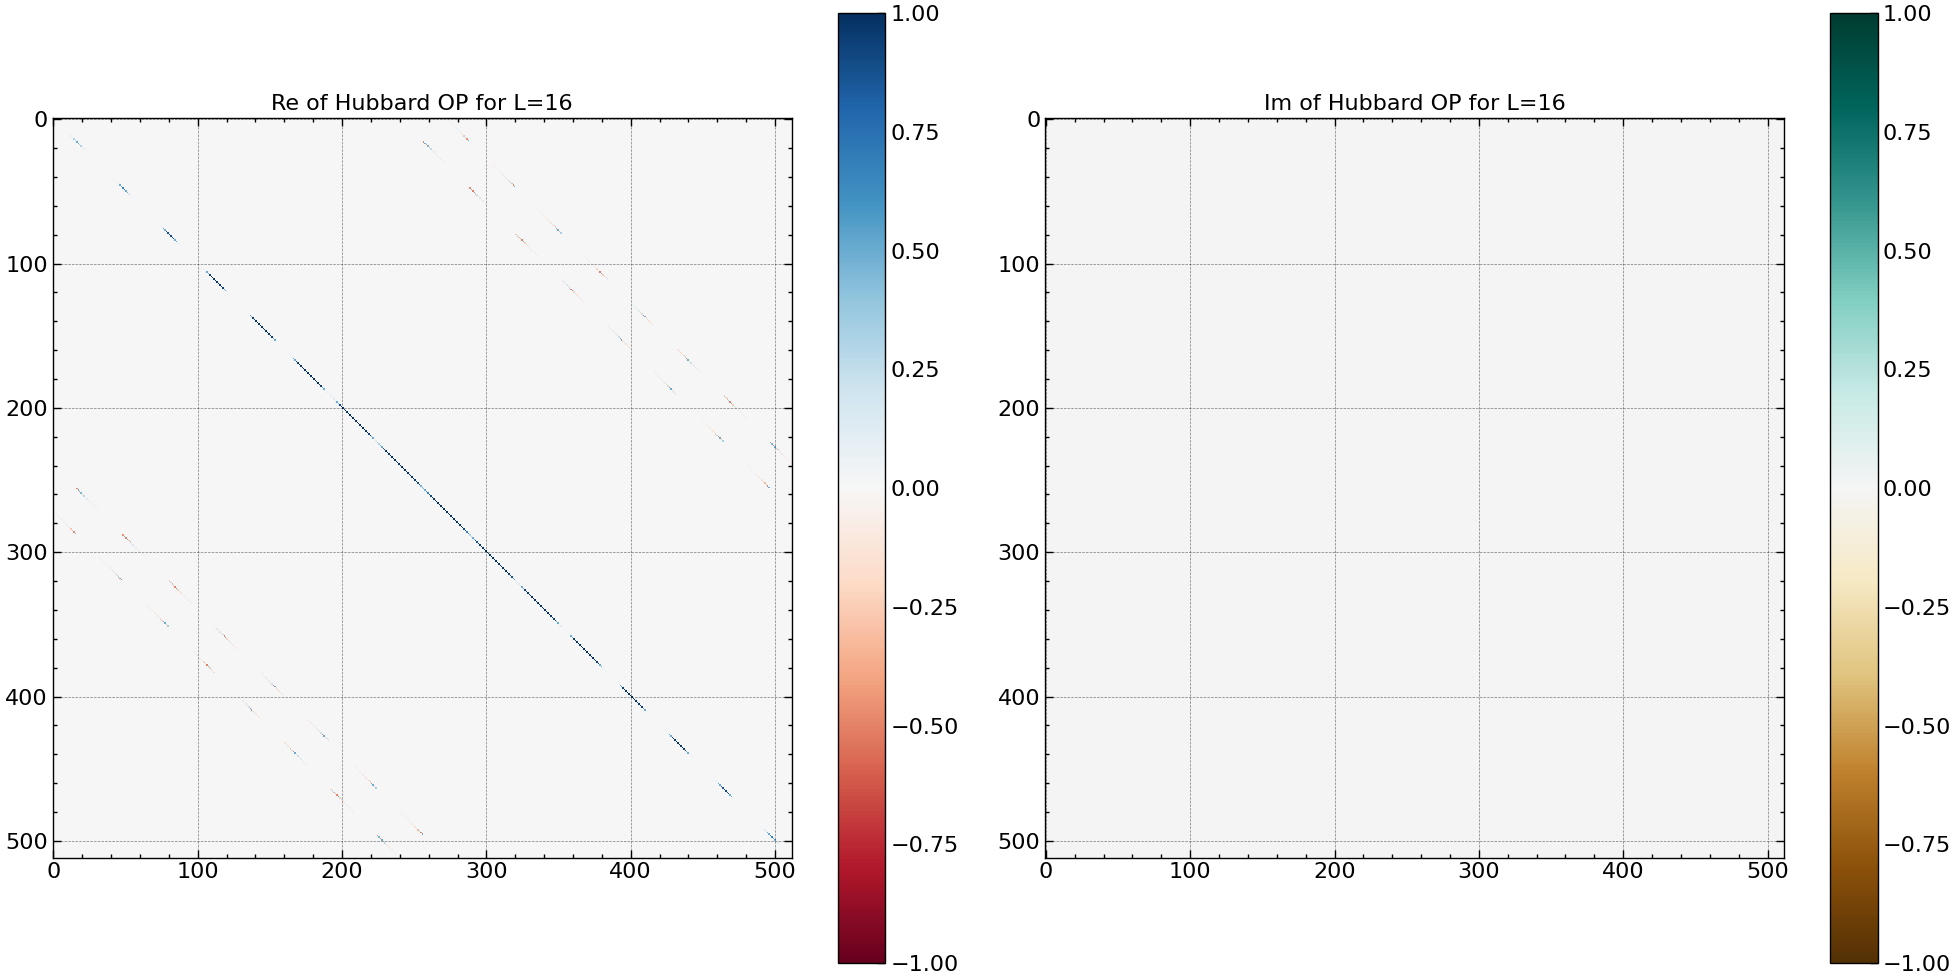

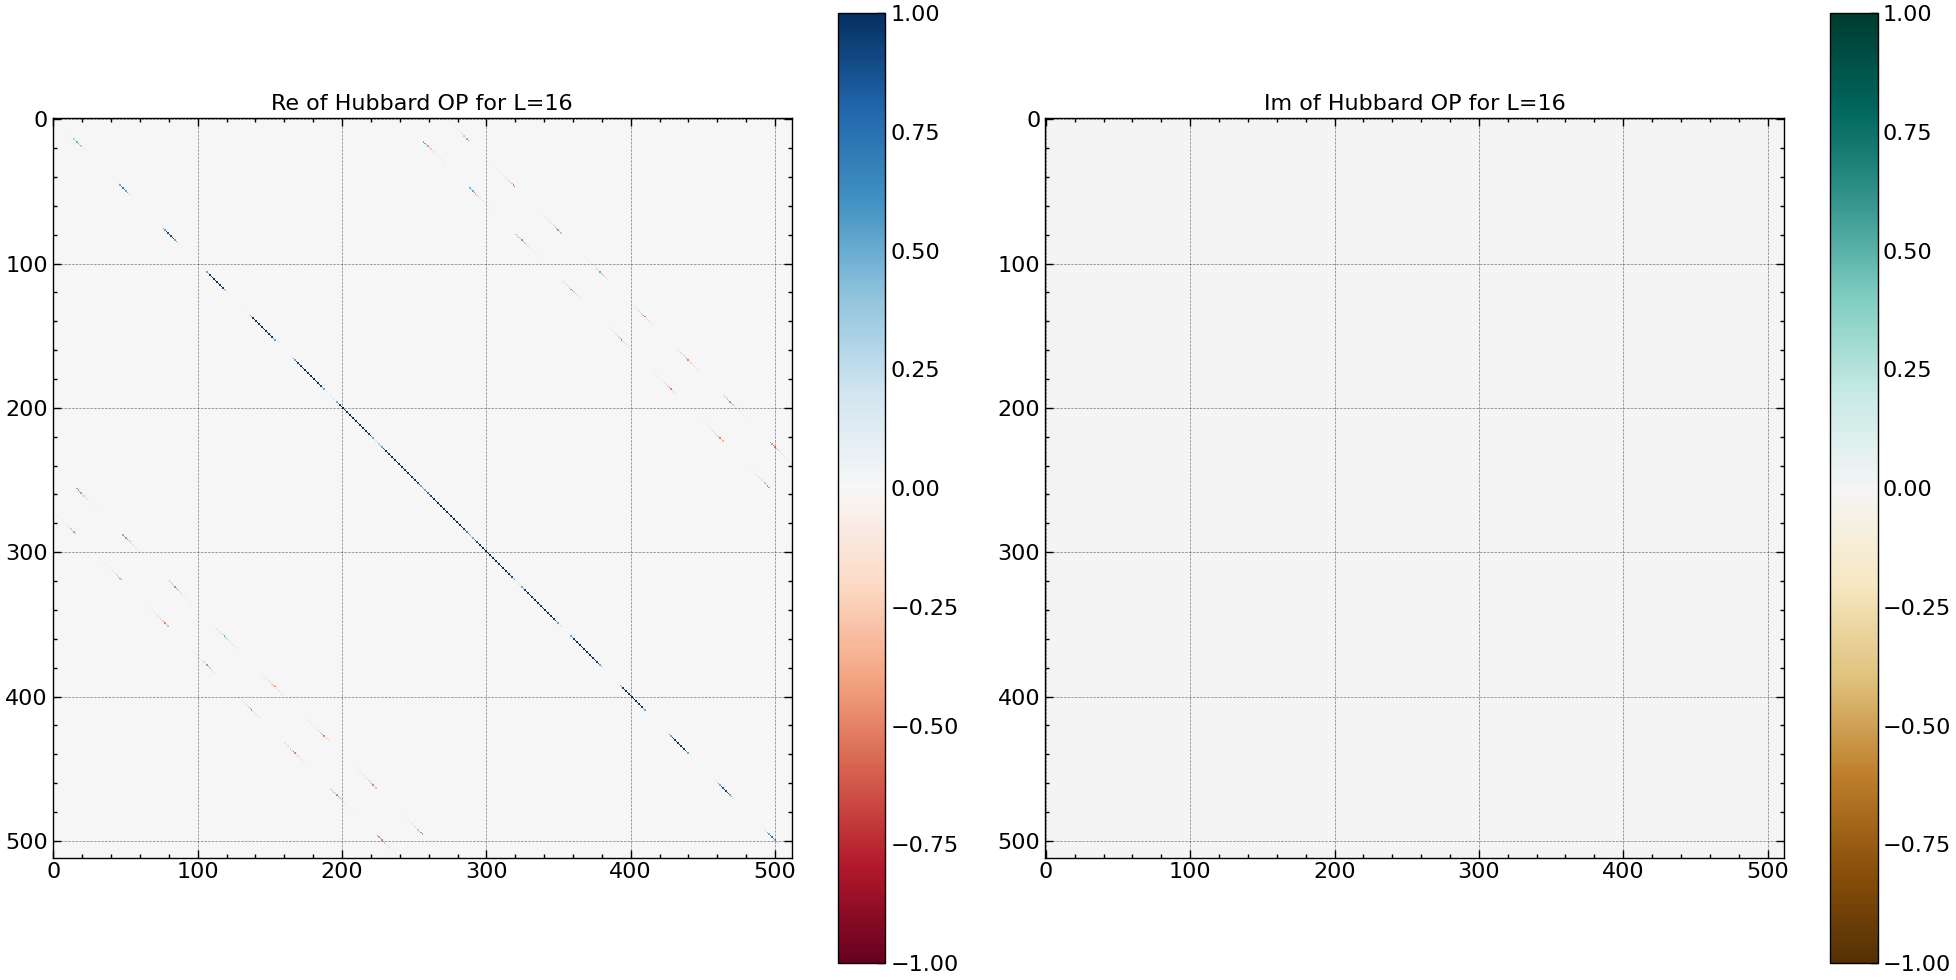

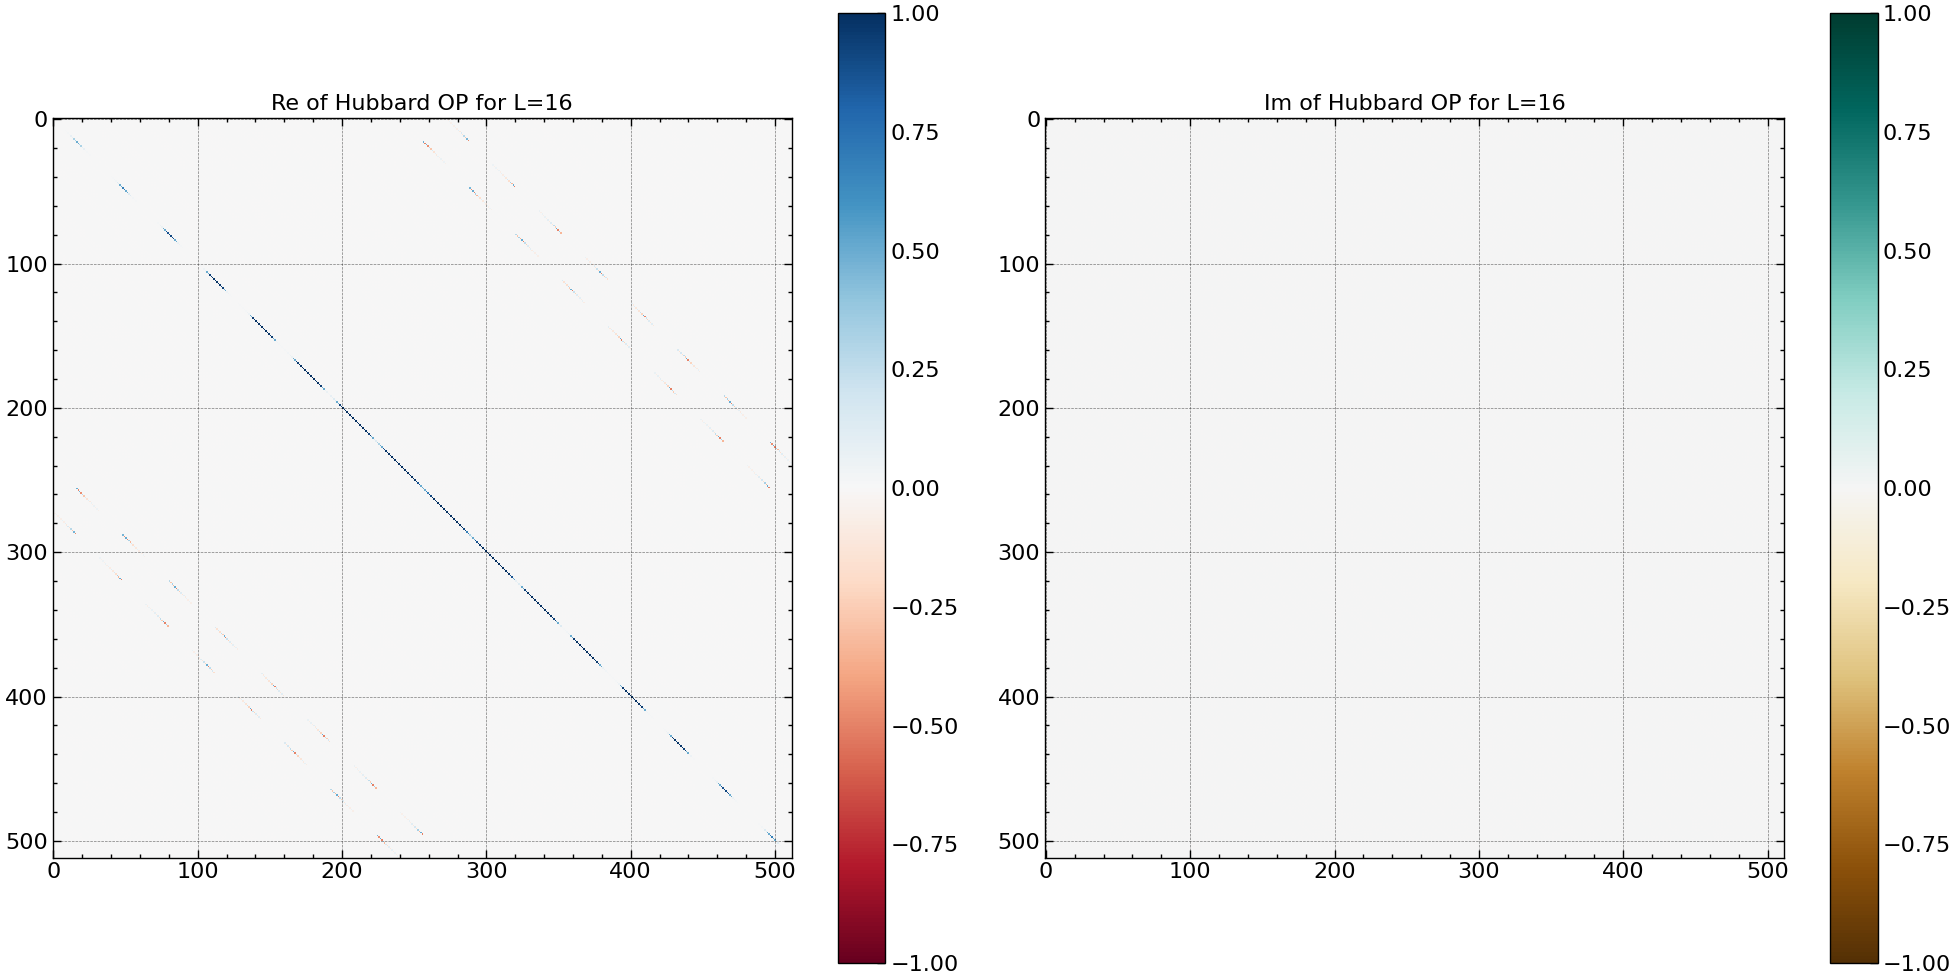

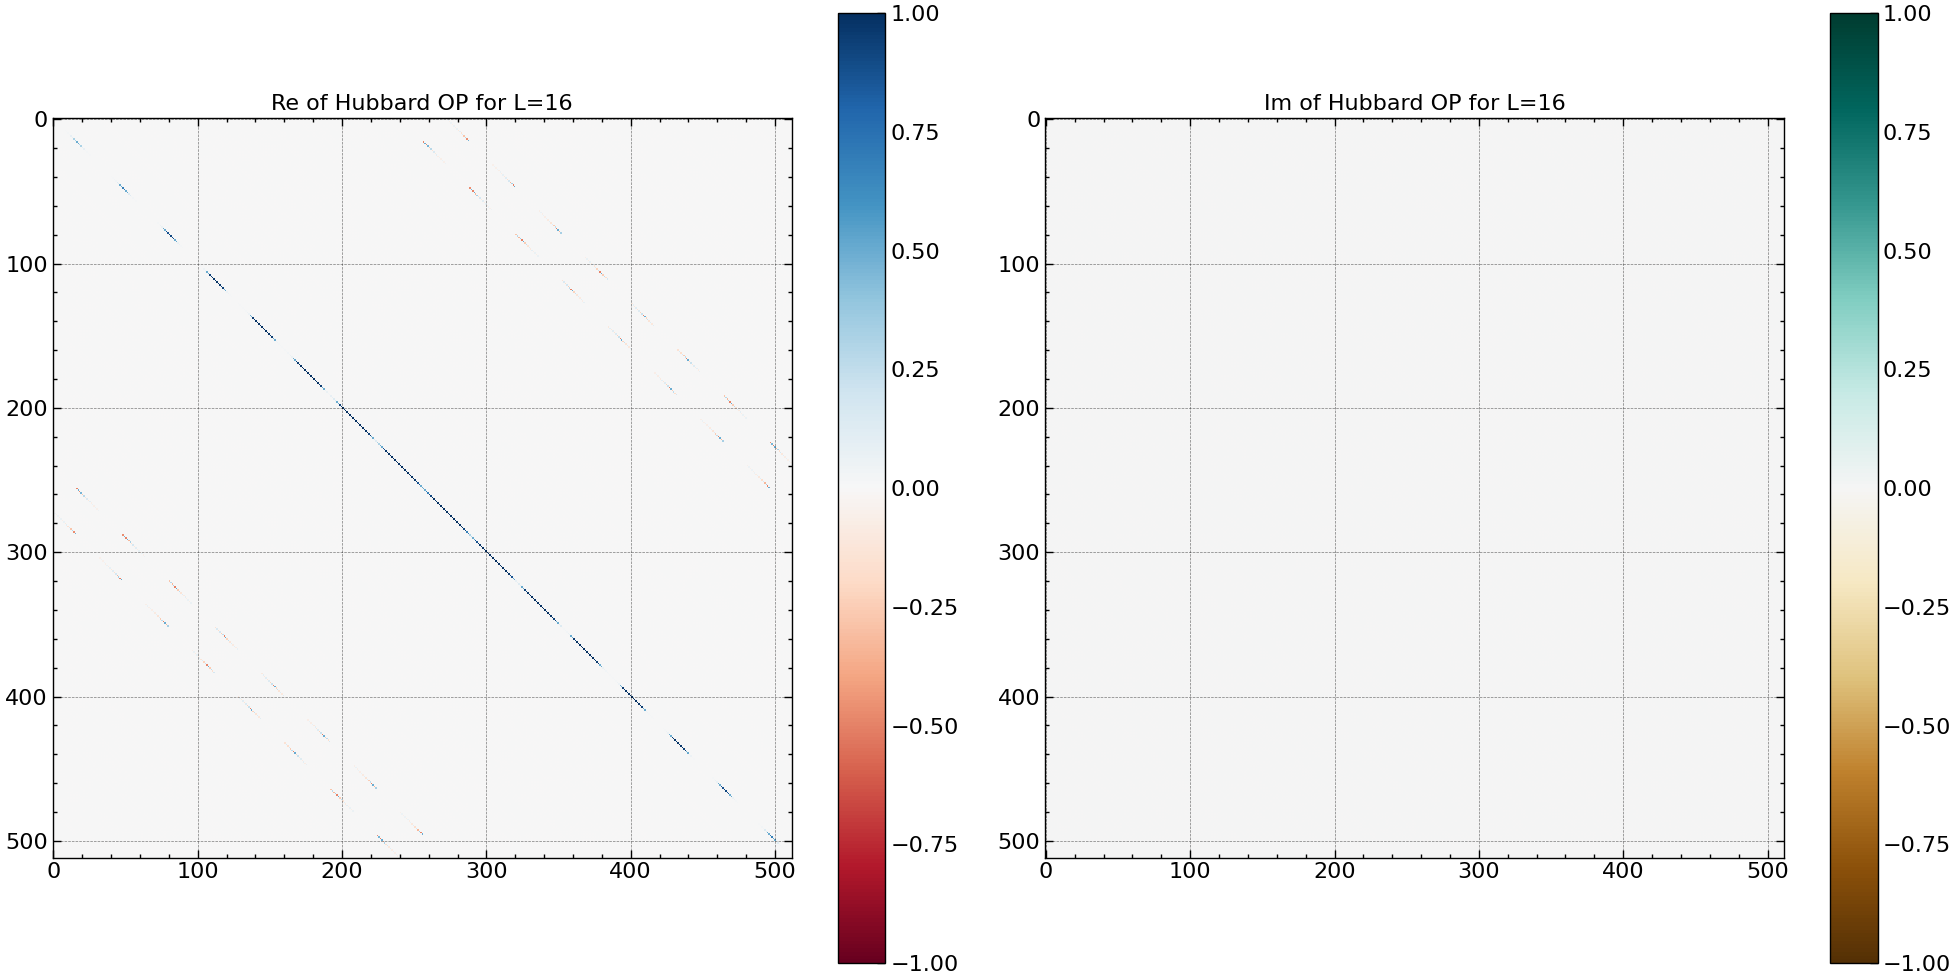

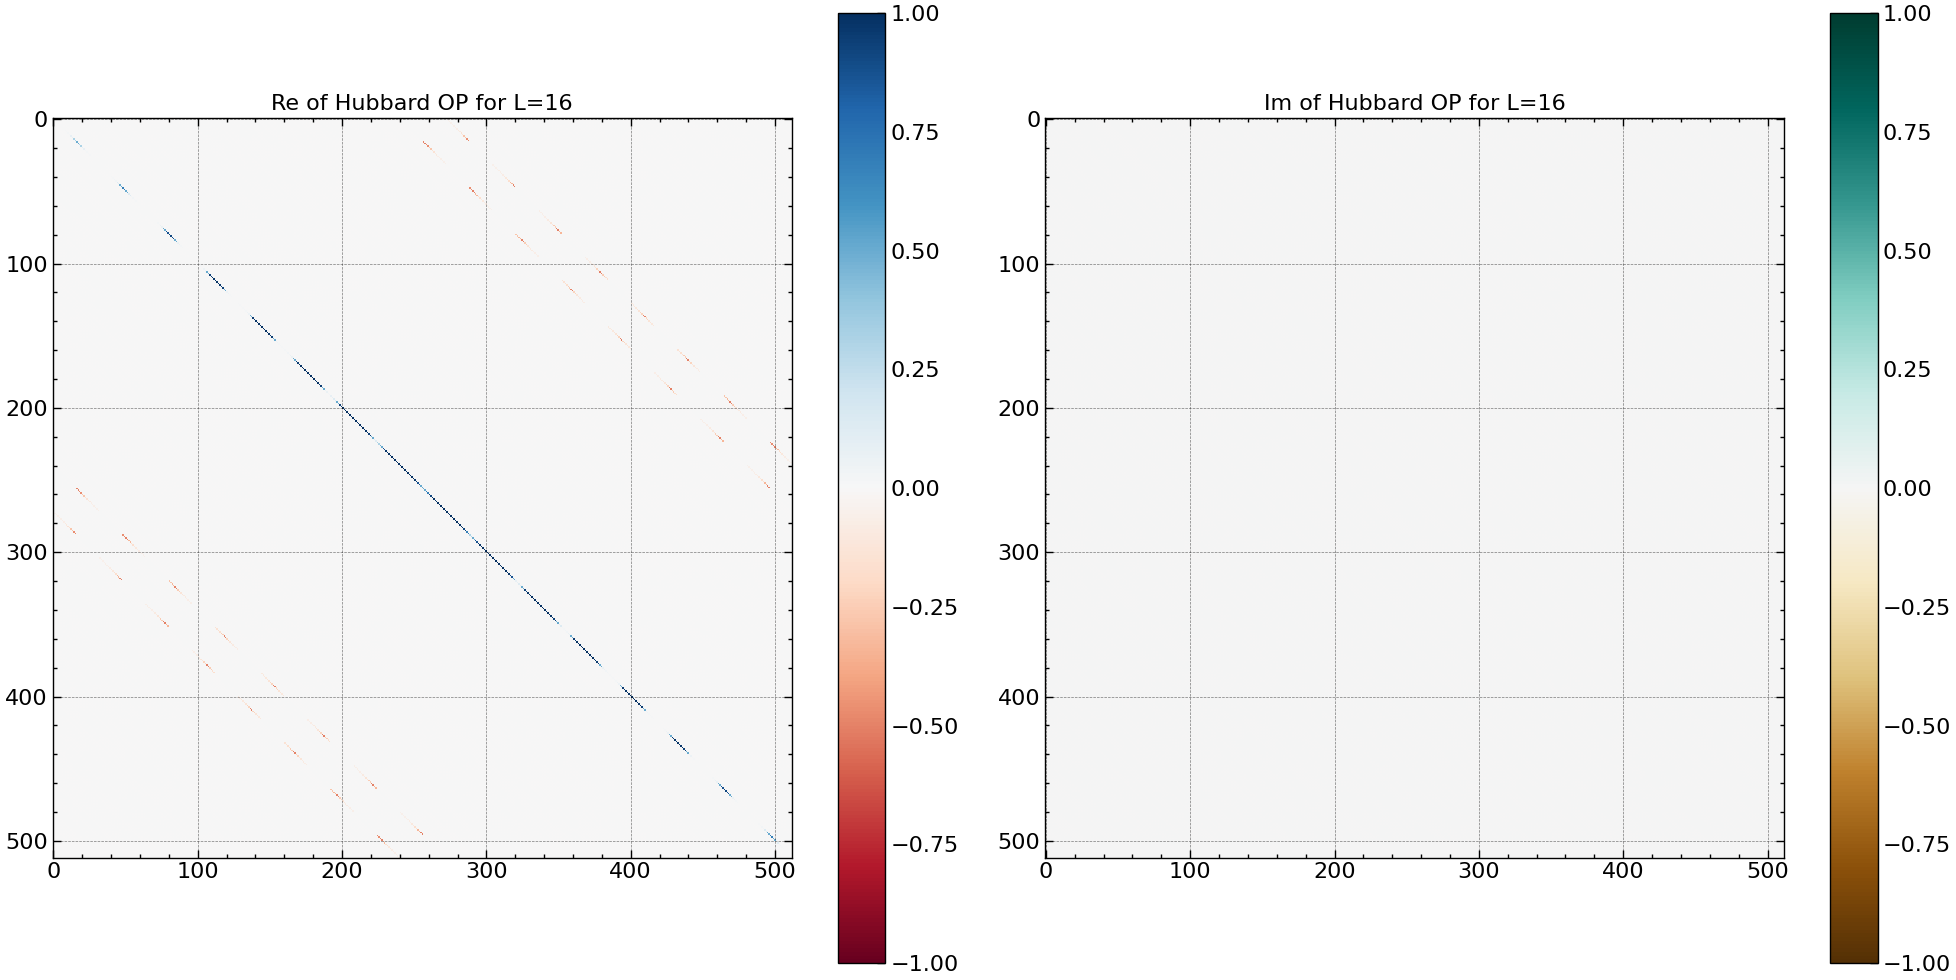

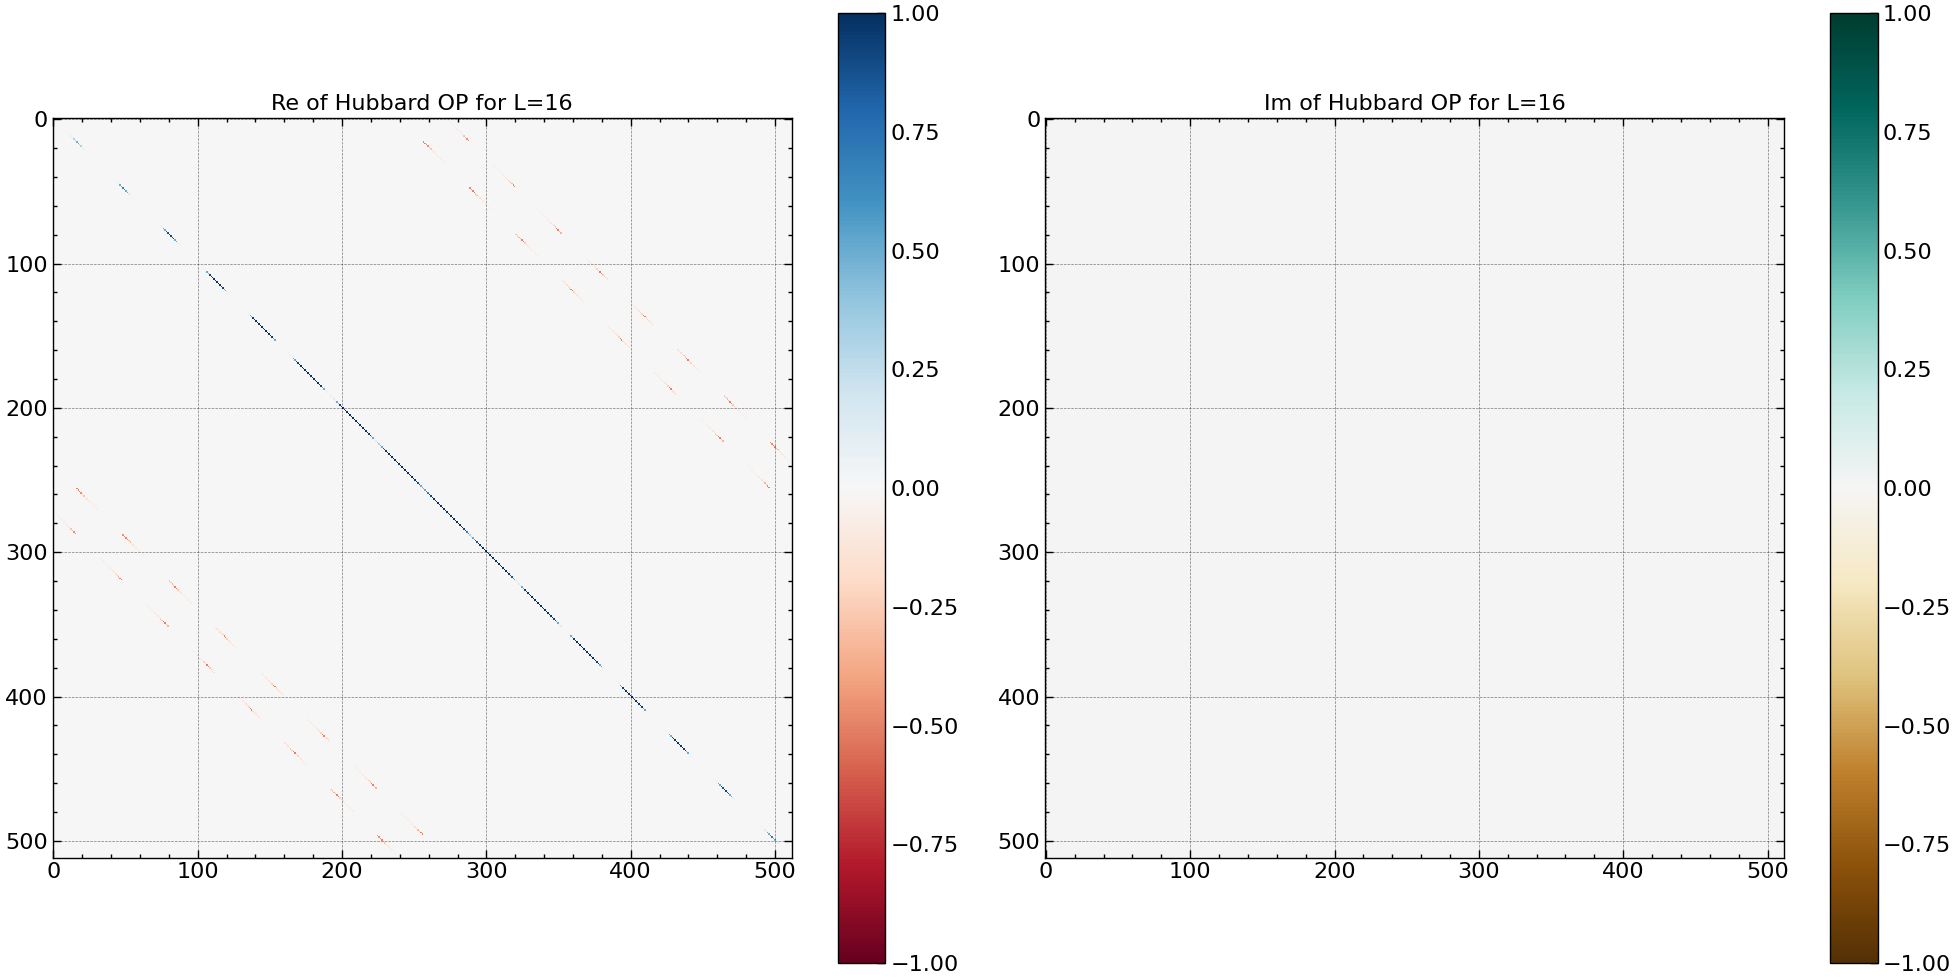

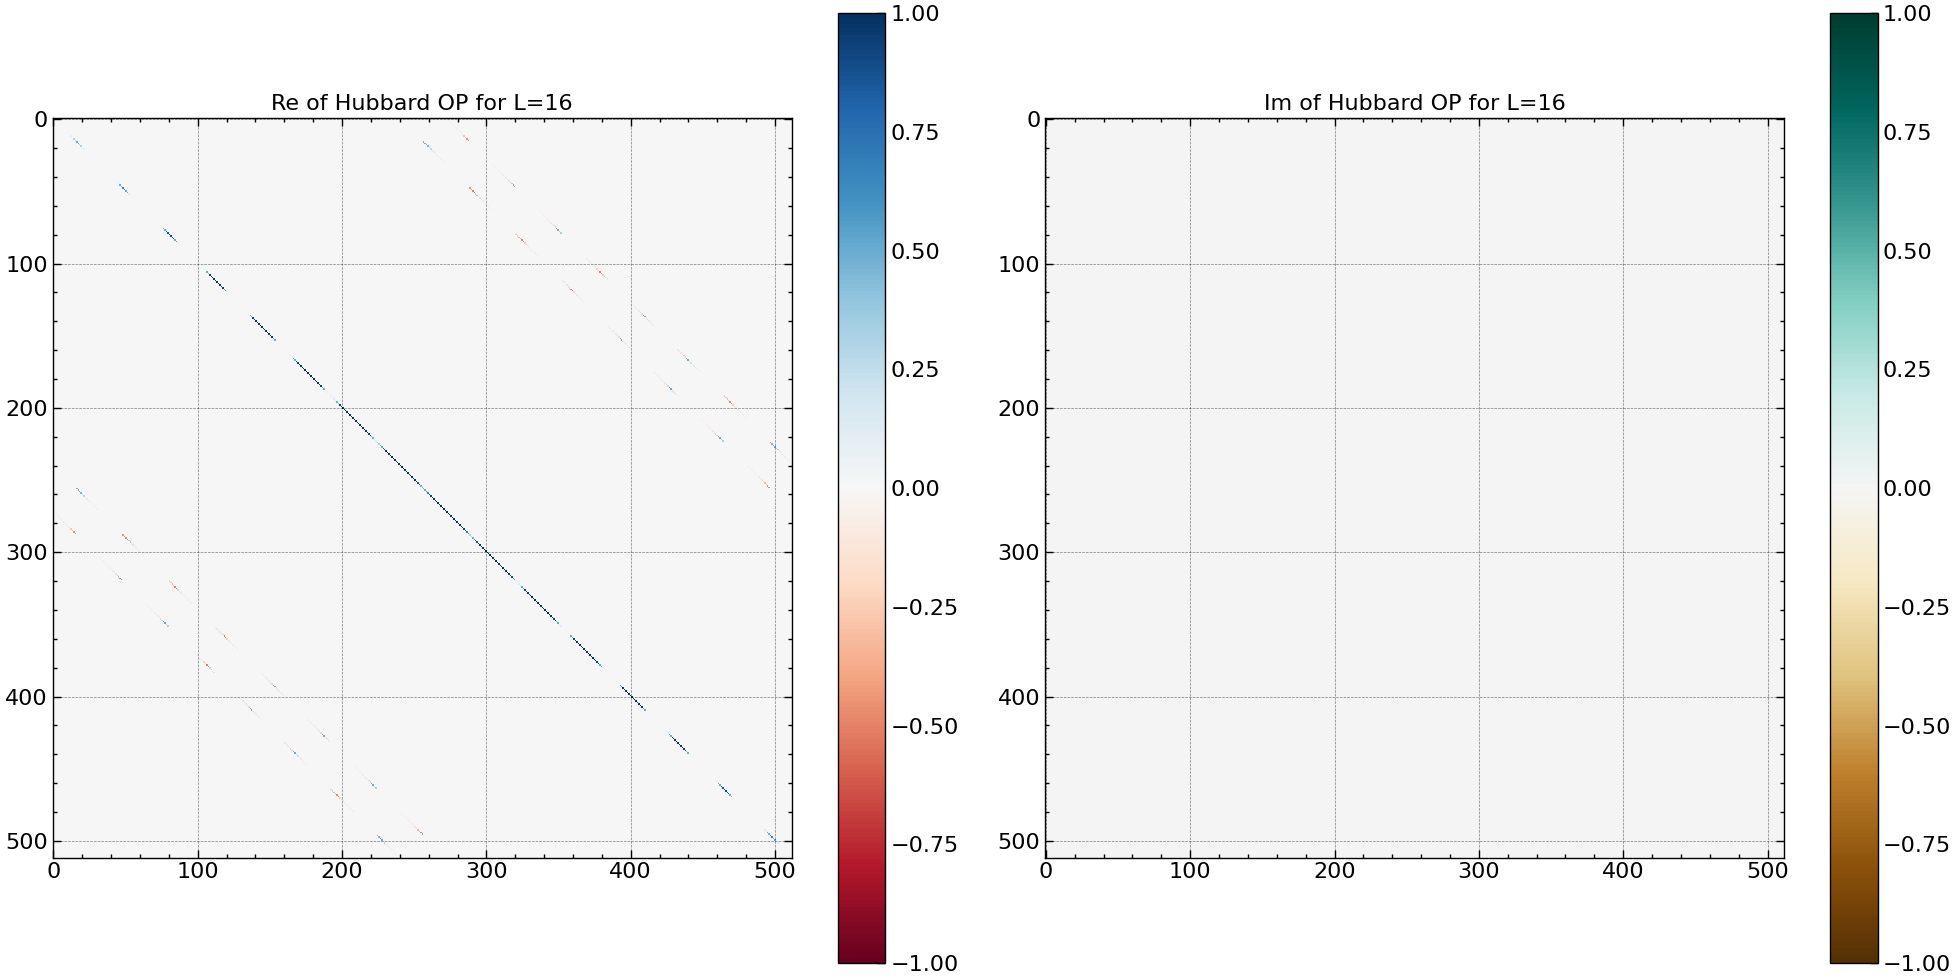

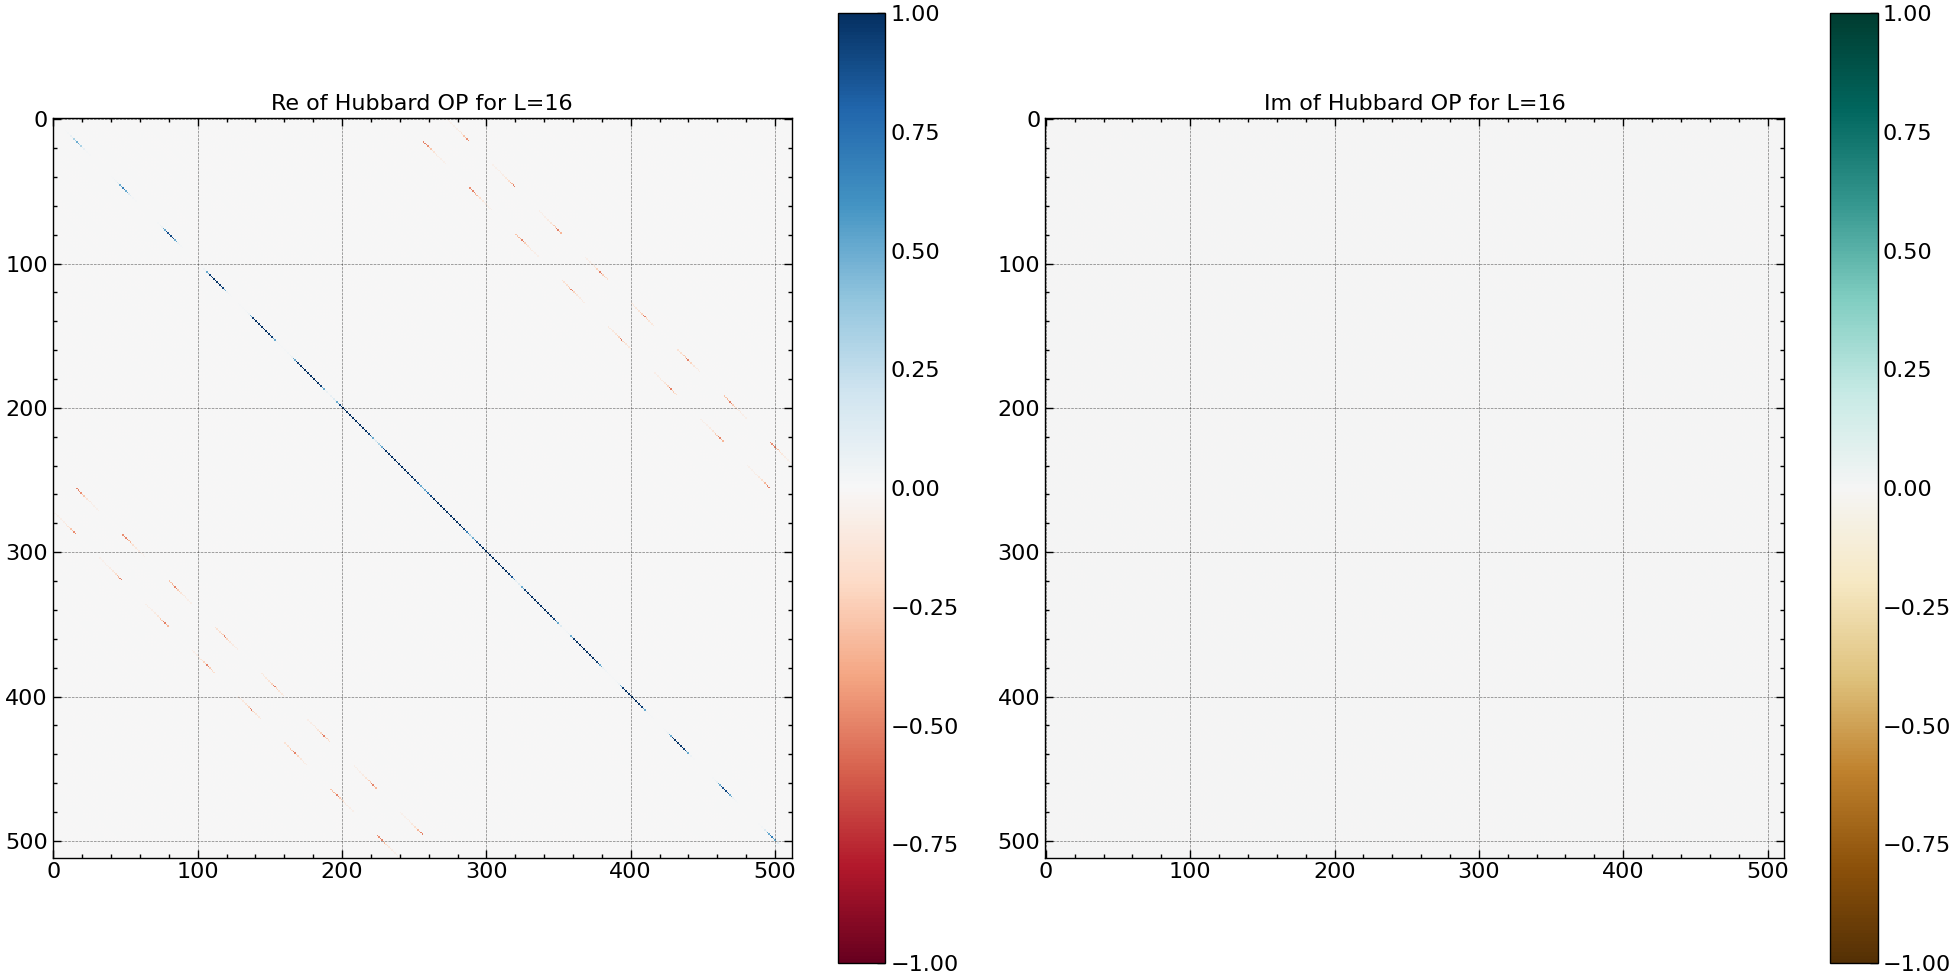

In [48]:
L=16
m_dim=2

# first find the lowest energy matrix
new_energy_list = []
with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_{L}_U_1_number_of_random_initials_10_occupied_{int(L**2 / 2)}_{int(L**2 / 2)}/P_HF_result.h5", 'r') as f:
    for initial in range(1, 11):
        new_energy_list.append(f[f'HF_energy_per_unit_cell_{initial}'][()])
        if f[f'gap_{initial}'][()] > 0.35:
            OP = np.transpose(f[f'P_HF_result_{initial}'][()]).conj()
            plot_complex_matrix(OP, f"Hubbard OP for L={L}")    

Energy: (-0.5655891271759536-7.928199995739853e-19j)
Gap: 0.4290922870911964


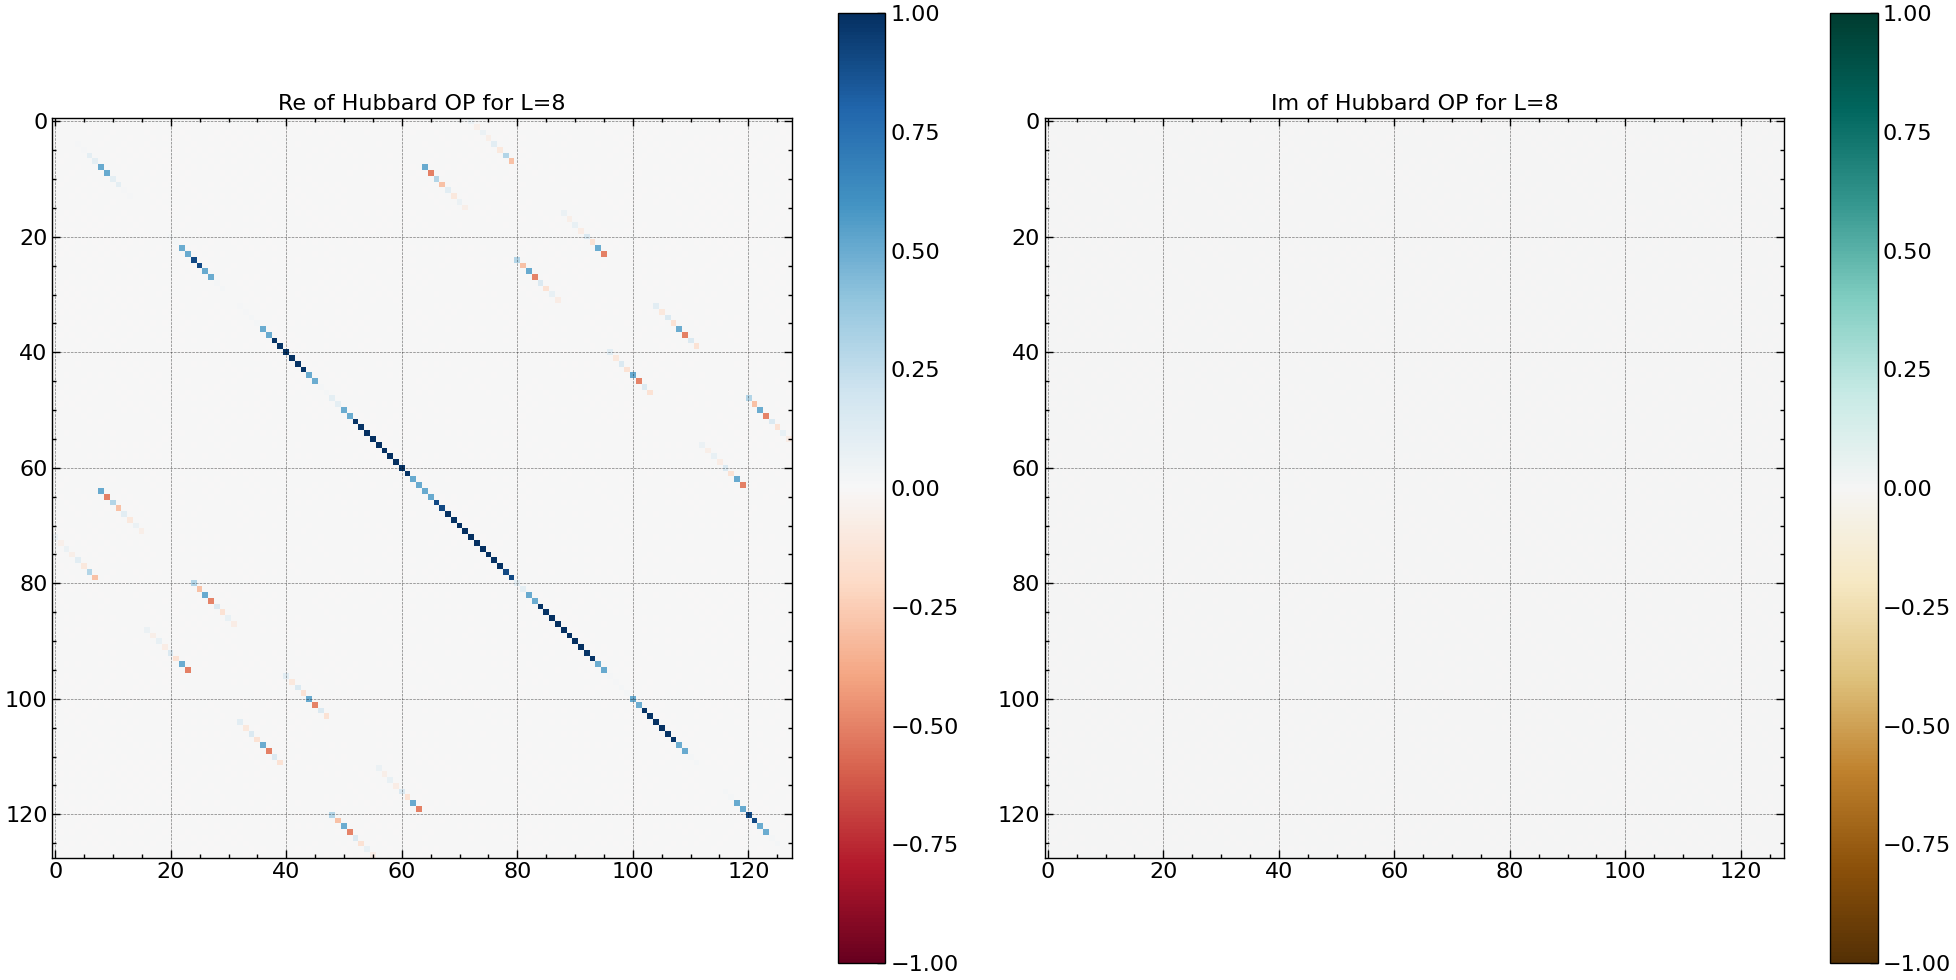

Energy: (-0.5655891151616252-4.465280723298808e-19j)
Gap: 0.42909223444710265


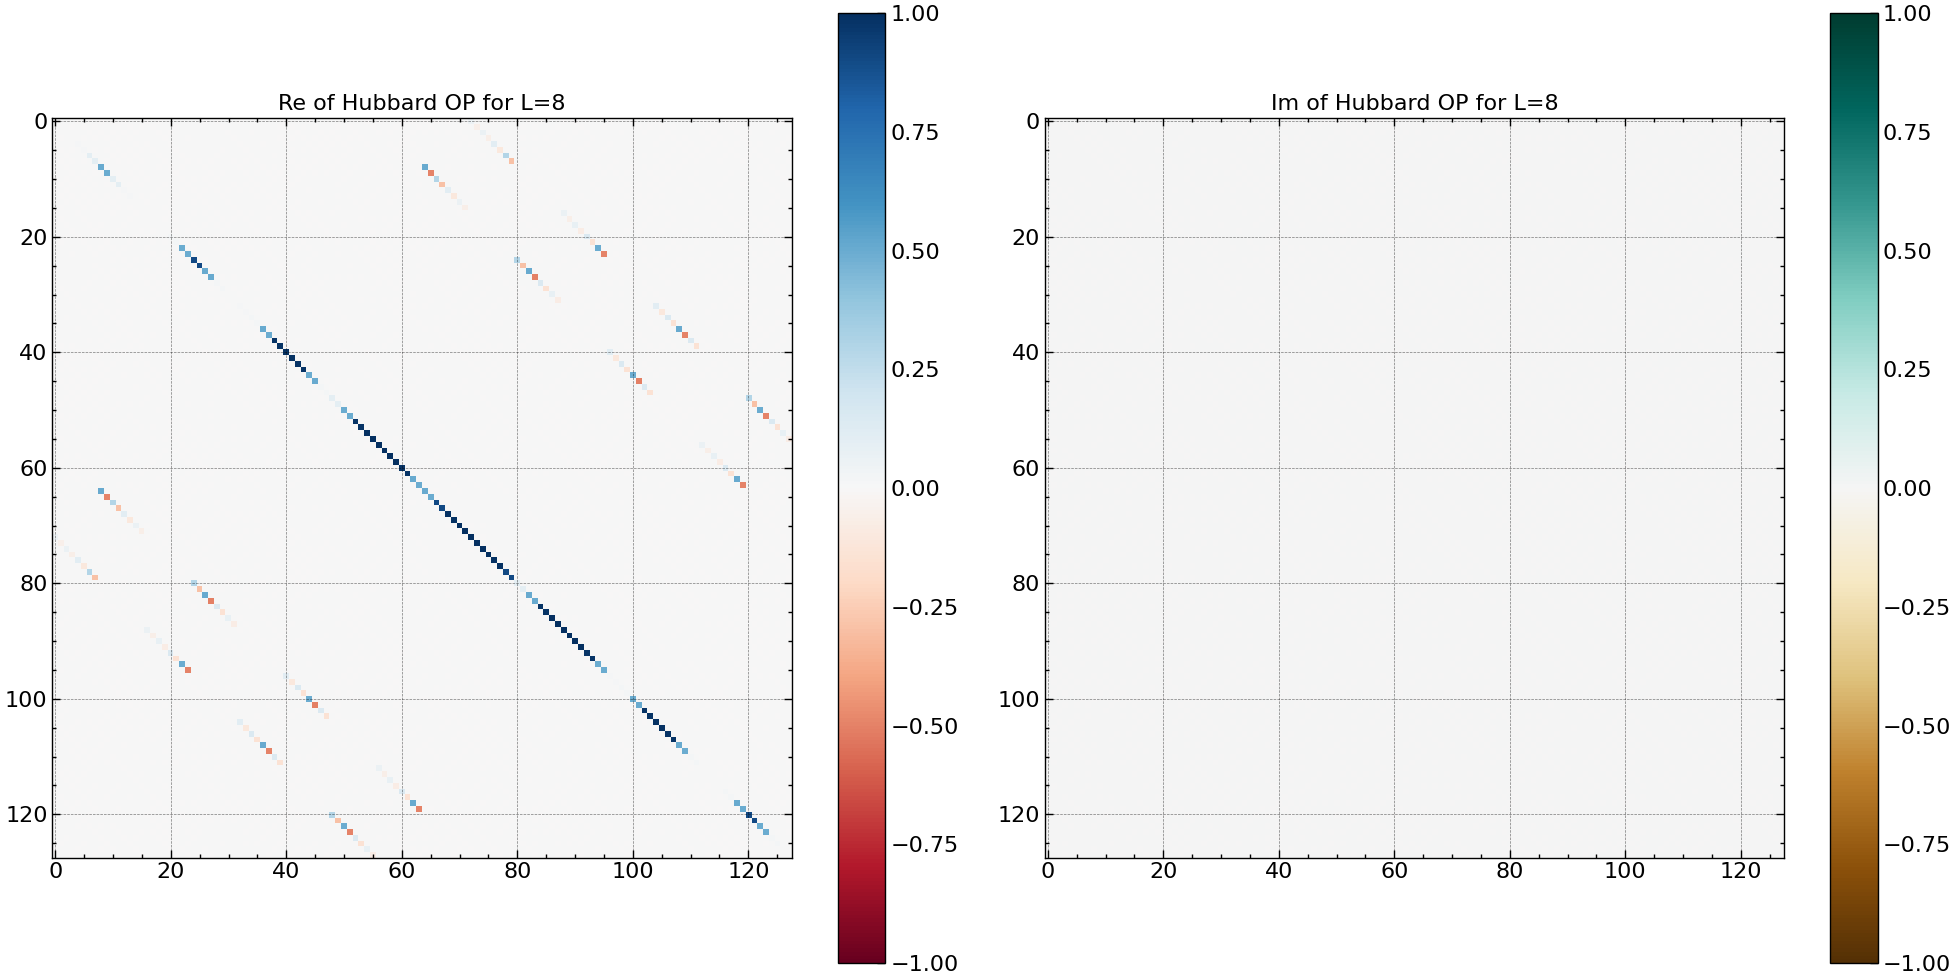

In [9]:
L=8
m_dim=2

with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_{L}_U_1_number_of_random_initials_10_occupied_{int(L**2 / 2)}_{int(L**2 / 2)}/P_HF_result.h5", 'r') as f:
    for initial in [1, 9]:
        print(f"Energy: {f[f'HF_energy_per_unit_cell_{initial}'][()]}")
        print(f"Gap: {f[f'gap_{initial}'][()]}")
        OP = np.transpose(f[f'P_HF_result_{initial}'][()]).conj()
        plot_complex_matrix(OP, f"Hubbard OP for L={L}")    

In [10]:
with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_{L}_U_1_number_of_random_initials_10_occupied_{int(L**2 / 2)}_{int(L**2 / 2)}/P_HF_result.h5", 'r') as f:
        OP_1 = np.transpose(f[f'P_HF_result_{1}'][()]).conj()
        OP_9 = np.transpose(f[f'P_HF_result_{9}'][()]).conj()
        print(np.max(np.abs(OP_1 - OP_9)))
        print(np.mean(np.abs(OP_1 - OP_9)))

2.505093777971368e-07
4.180774900159608e-09



Plotting translation breaking matrix...


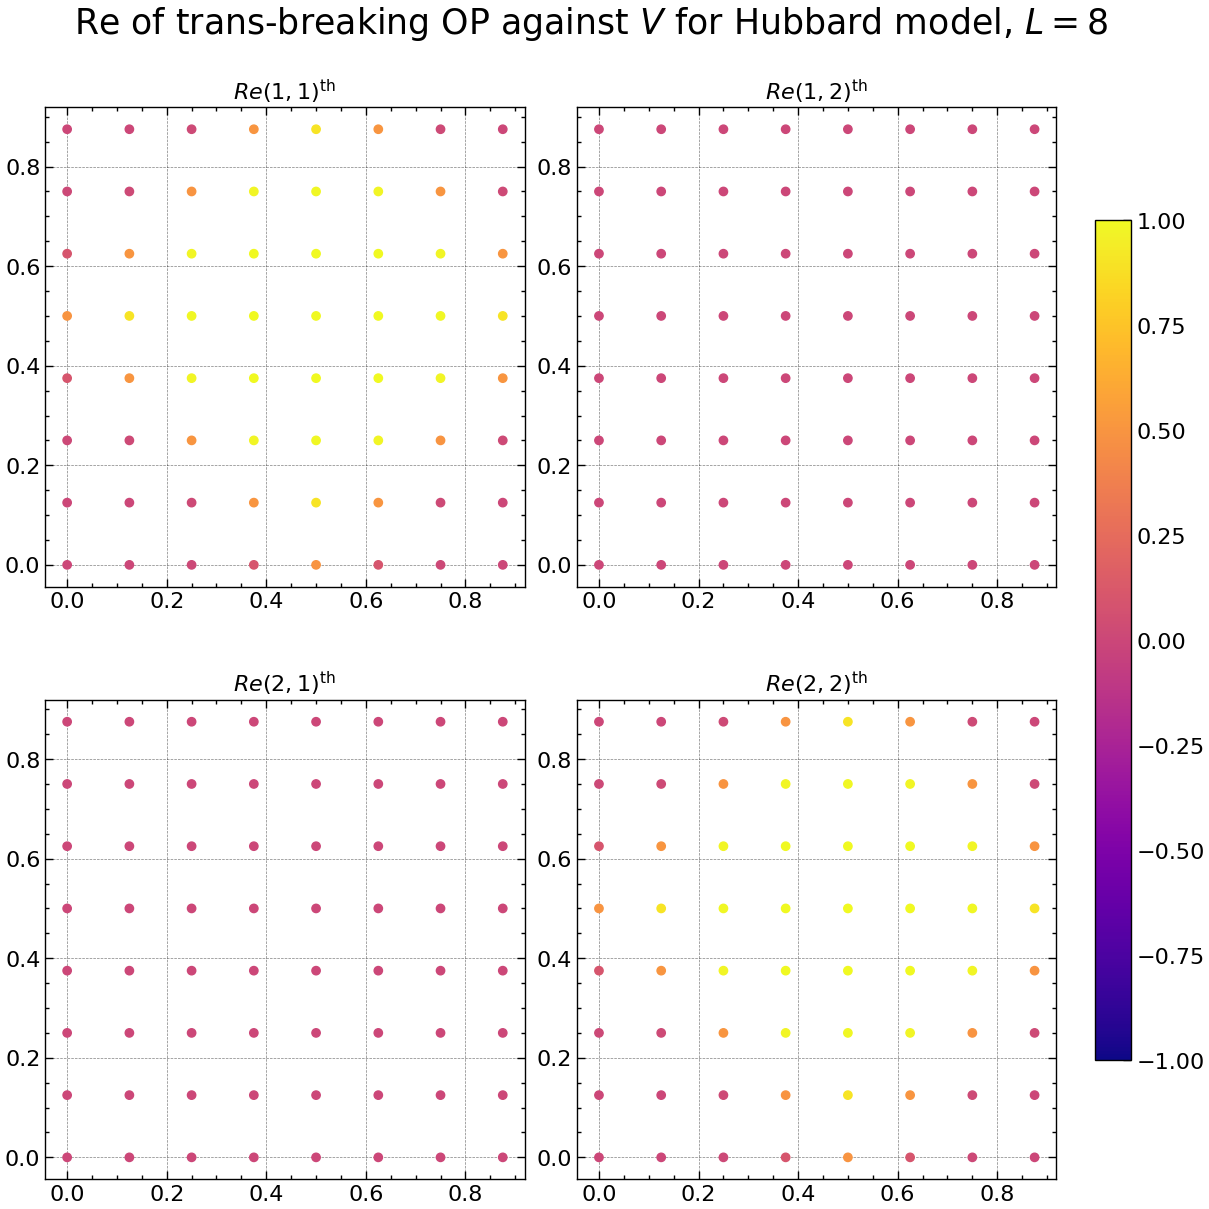

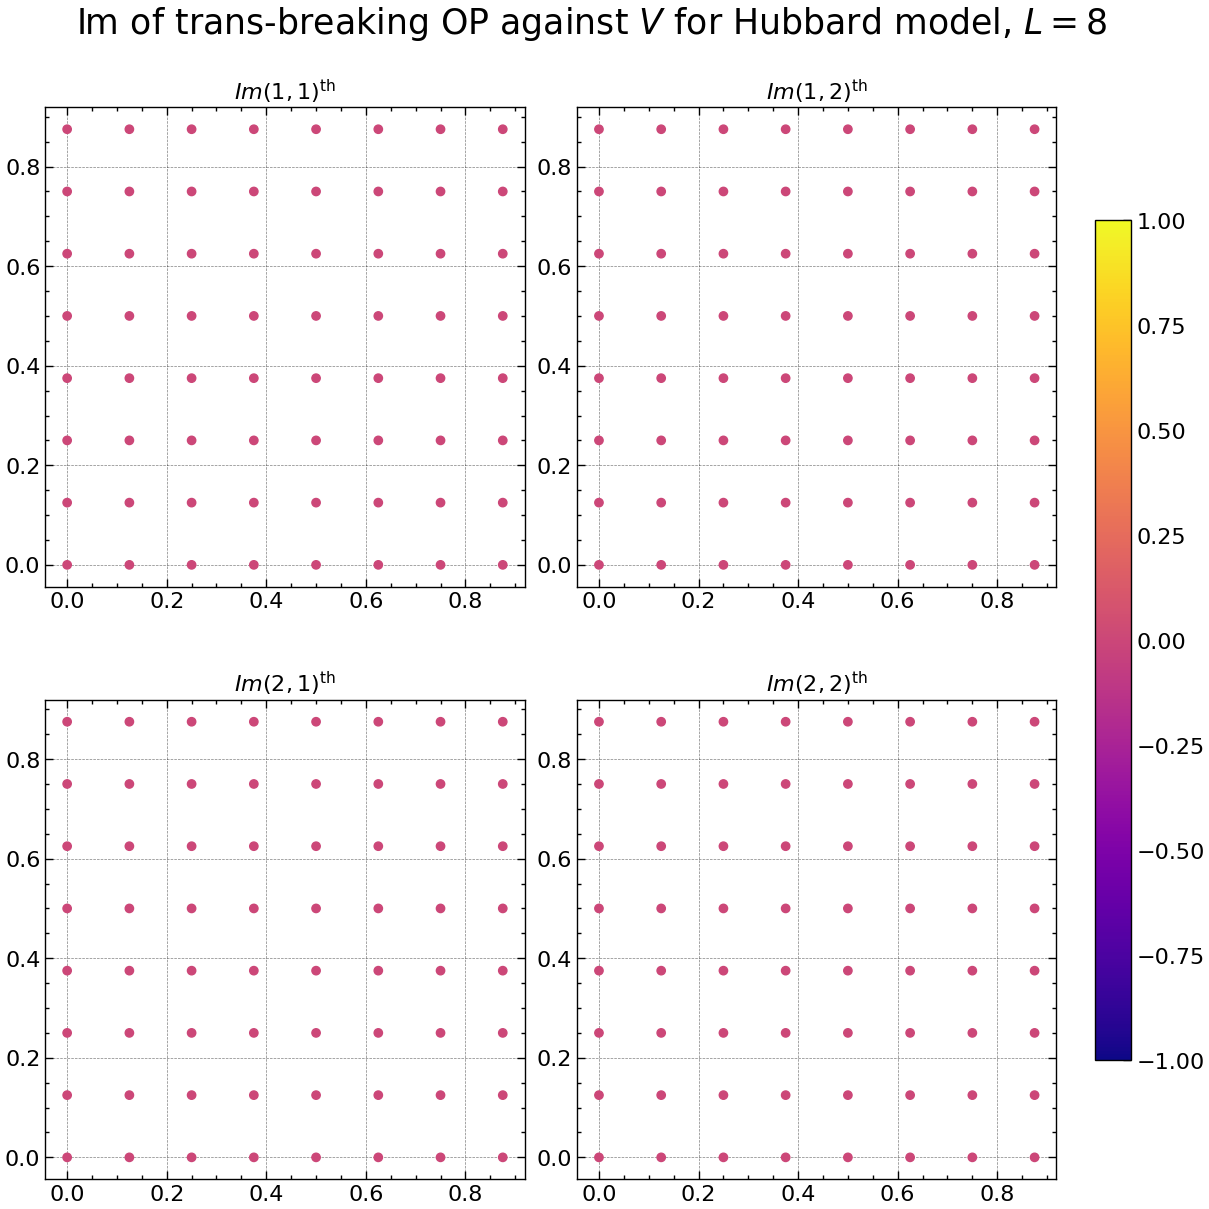

Done!

Plotting translation breaking matrix...


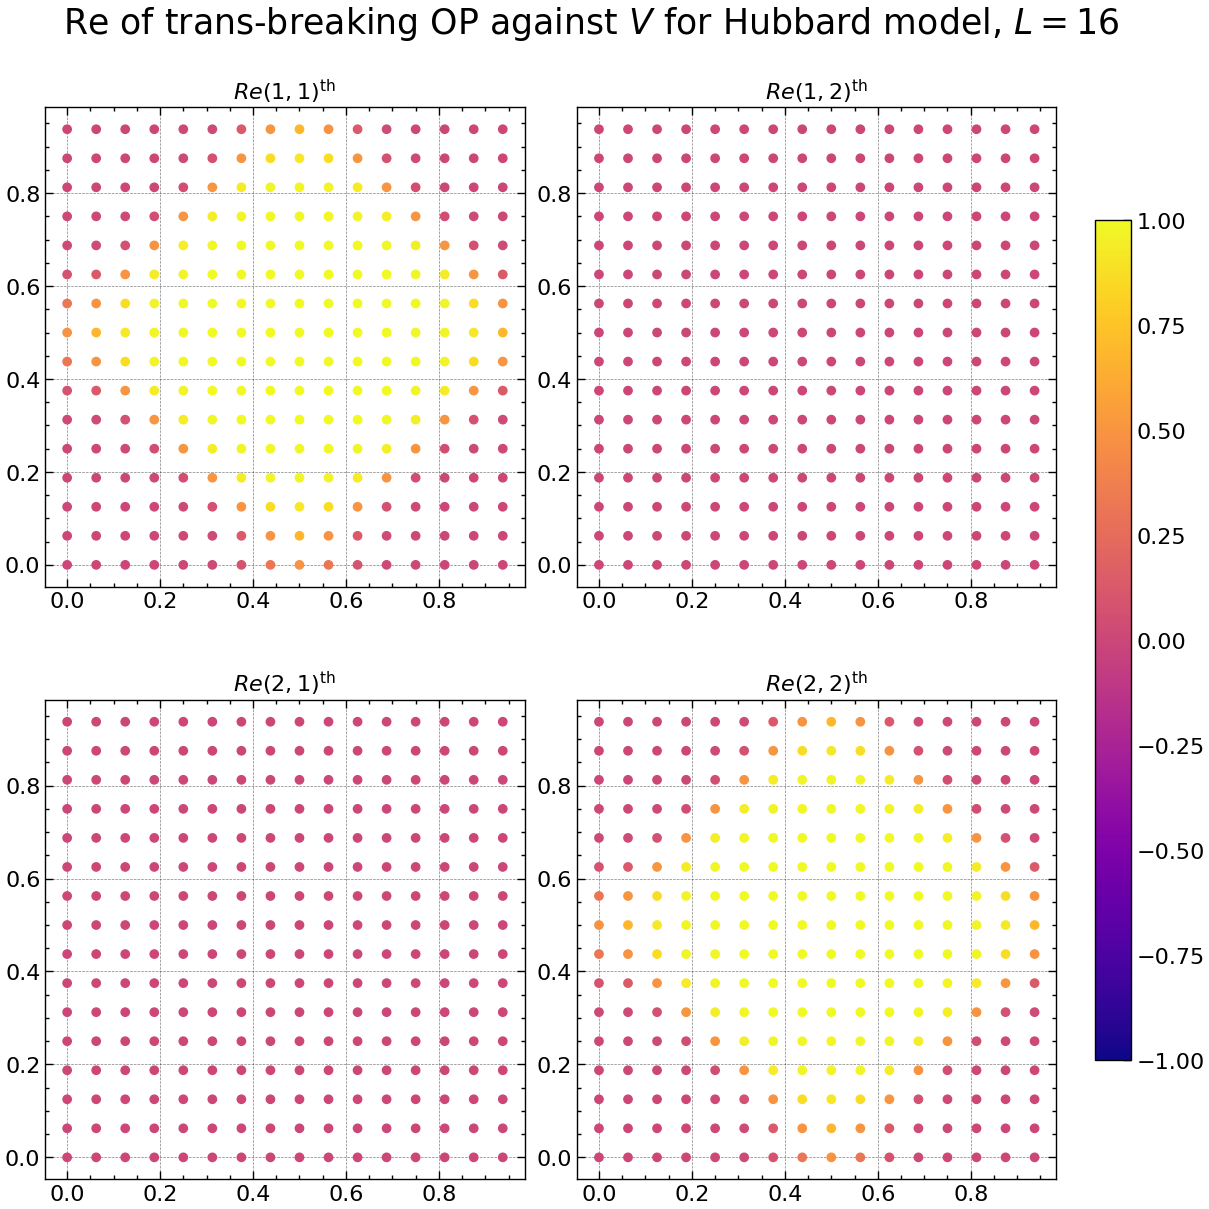

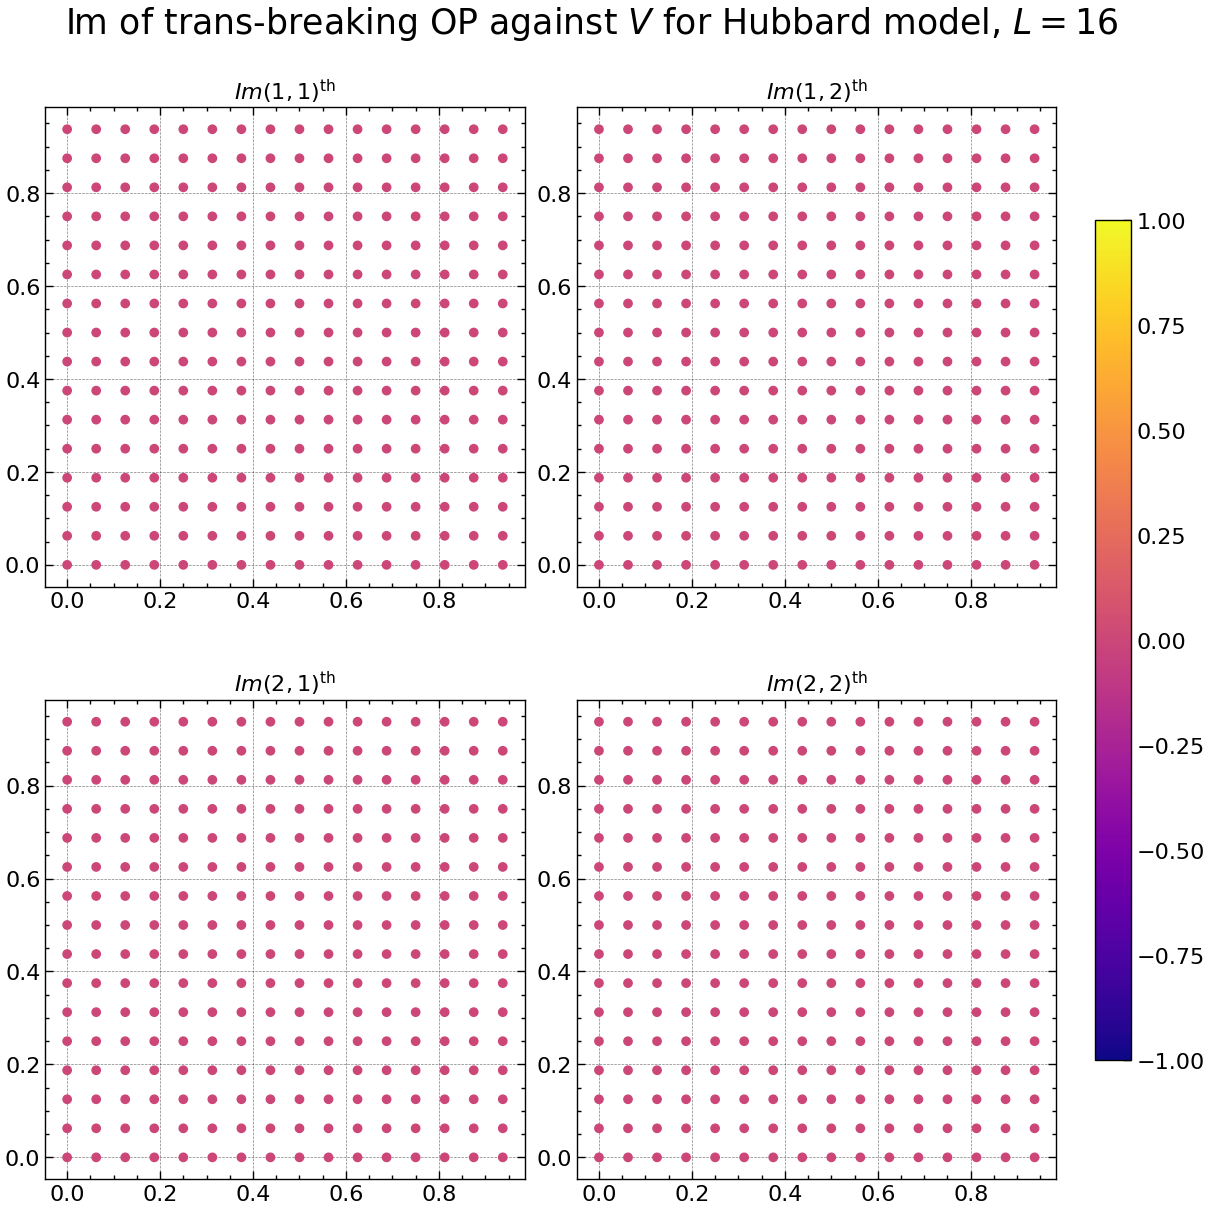

Done!


In [52]:
def plot_hubbard(L):
    # first find the lowest energy matrix
    new_energy_list = []
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_{L}_U_1_number_of_random_initials_10_occupied_{int(L**2 / 2)}_{int(L**2 / 2)}/P_HF_result.h5", 'r') as f:
        for initial in range(1, 11):
            new_energy_list.append(f[f'HF_energy_per_unit_cell_{initial}'][()])
        new_energy_list = np.array(new_energy_list)
        idx = np.argmin(new_energy_list.real) + 1
        OP = np.transpose(f[f'P_HF_result_{idx}'][()].conj())

    # get 2x2 across diagonal
    diagonal_tensor = np.zeros((L, L, 2, 2), dtype=np.complex128)
    V = np.zeros((L, L, 2))
    for k_1 in range(0, L):
        for k_2 in range(0, L):
            pos = (k_1*2*L + k_2*2)
            matrix_2x2 = OP[pos:pos+2, pos:pos+2]
            diagonal_tensor[k_1, k_2, :, :] = matrix_2x2

            v_1 = k_1 / L
            v_2 = k_2 / L
            V[k_1, k_2, :] = np.array([v_1, v_2])

    print(f"\nPlotting translation breaking matrix...")   # for u={u}
    plot_diagonal_blocks(diagonal_tensor, V, f"Hubbard model, $L={L}$")
    print("Done!")

plot_hubbard(8)
plot_hubbard(16)

In [ ]:
for dist in [50, 30, 15, 10, 2, 0.1]:
    # first find the lowest energy matrix
    new_energy_list = []
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_new/Unrestricted_HF_Valley_1_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_gate_to_gate_dist_{dist}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 11):
            new_energy_list.append(f[str(initial)]['E_tot_per_unit_cell'][()])
        new_energy_list = np.array(new_energy_list)
        idx = np.argmin(new_energy_list.real) + 1
        OP = np.transpose(f[str(idx)]['OP_mat'][()])
        gap = f[str(idx)]['gap'][()].item().real
    
    # get 4x4 across diagonal
    L = 6
    diagonal_tensor = np.zeros((L, L, 2, 2), dtype=np.complex128)
    V = np.zeros((L, L, 2))
    for k_1 in range(0, L):
        for k_2 in range(0, L):
            pos = (k_1*2*L + k_2*2)
            matrix_4x4 = OP[pos:pos+2, pos:pos+2]
            diagonal_tensor[k_1, k_2, :, :] = matrix_4x4

            v_1 = k_1 / L
            v_2 = k_2 / L
            V[k_1, k_2, :] = np.array([v_1, v_2])
    
    print(f"\nPlotting translation breaking matrix...")   # for u={u}
    plot_diagonal_blocks(diagonal_tensor, V, dist, gap)
    print("Done!")

In [ ]:
# code for translation-breaking case
for u in [0.01, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    # first find the lowest energy matrix
    new_energy_list = []
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF_trans_breaking/Unrestricted_HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_test_ulist_{u}/HF_results_data.h5", 'r') as f:
        for initial in range(1, 11):
            new_energy_list.append(f[str(initial)]['E_tot_per_unit_cell'][()])
        new_energy_list = np.array(new_energy_list)
        idx = np.argmin(new_energy_list.real) + 1
        OP = np.transpose(f[str(idx)]['OP_mat'][()])
        gap = f[str(idx)]['gap'][()].item().real
    
    # get 4x4 across diagonal
    diagonal_tensor = np.zeros((6, 6, 4, 4), dtype=np.complex128)
    V = np.zeros((6, 6, 2))
    for k_1 in range(0, 6):
        for k_2 in range(0, 6):
            pos = (k_1*4*6 + k_2*4)
            matrix_4x4 = OP[pos:pos+4, pos:pos+4]
            diagonal_tensor[k_1, k_2, :, :] = matrix_4x4

            v_1 = k_1 / 6
            v_2 = k_2 / 6
            V[k_1, k_2, :] = np.array([v_1, v_2])
    
    print(f"\nPlotting translation breaking matrix for u={u}")
    plot_diagonal_blocks(diagonal_tensor, V, gap)
    print("Done!")

### More Data Visualization

In [ ]:
# with h5py.File(output_filename, "r") as out_file:
#     # first, get all the energies
#     energy_list = []
#     for i in range(1, 20_000 + 1):  # i should go from 1 to 10000
#         energy_list.append(out_file[f"HF_energy_per_unit_cell_{i}"][()])

# energy_list = np.array(energy_list)
# min_energy = np.min(energy_list.real)
# print(min_energy)

# print((np.abs(energy_list.real - min_energy) < 1e-4).sum())

# with h5py.File(output_filename, "r") as out_file:
#     count = 0
#     for i in range(1, 20_000 + 1):
#         new_energy = out_file[f"HF_energy_per_unit_cell_{i}"][()].real
#         if(np.abs(new_energy - min_energy) < 1e-4):
#             plot_complex_matrix(np.transpose(out_file[f"P_HF_result_{i}"][()]))
#             count += 1
#         if count >= 10:
#             break

In [ ]:
def plot_MxM_matrix(matrix: np.ndarray):
    # matrix should be of shape (4L^2, 4L^2)
    # Find the global min and max for the color scale ---
    c_min = np.min(matrix)
    c_max = np.max(matrix)
    
    # now reshape to get it in the right form
    four_L_square = matrix.shape[0]

    # find out what L is
    L_square = four_L_square // 4
    L = int(math.sqrt(L_square))

    # start plotting
    figure, axes = plt.subplots(L_square, L_square, figsize=(12, 12))

    # We will store the last scatter plot in a variable to use for the colorbar
    im = None

    for i in range(L_square):
        for j in range(L_square):
            alpha_matrix_4x4 = matrix[4*i : 4*i + 4, 4*j : 4*j + 4]
            ax = axes[i, j]
            im = ax.imshow(alpha_matrix_4x4, cmap="plasma", vmin=c_min, vmax=c_max)
    
    # general settings for the whole figure
    figure.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the colorbar
    figure.suptitle('OP', y=1.03, fontsize=25)

    # --- New: Create a single colorbar for the entire figure ---
    # Create a new axes for the colorbar on the right side of the figure
    cbar_ax = figure.add_axes([0.92, 0.15, 0.03, 0.7]) # [left, bottom, width, height]
    figure.colorbar(im, cax=cbar_ax)

    # Show plot
    plt.show()

In [ ]:
plot_MxM_matrix(lowest_energy_matrix.real)

### Data Preprocessing

In [8]:
# helper function to convert an MxM matrix into a sequence of flattened 32-dimensional vectors
def make_4x4_matrices(array: np.ndarray) -> np.ndarray:
    # array should be of shape (4L^2, 4L^2)
    # first we need to find L
    four_L_square = array.shape[0]
    L_square = four_L_square // 4
    L = int(round(math.sqrt(L_square)))

    vector_list = []

    # iterate over the four indices
    for k_1 in range(L):
        for k_2 in range(L):
            for k_1_prime in range(L):
                for k_2_prime in range(L):
                    row_index = (k_1 * 4 * L) + (k_2 * 4)
                    col_index = (k_1_prime * 4 * L) + (k_2_prime * 4)

                    # now get the 4x4 matrix at these coordinates
                    alpha_4x4_matrix = array[row_index : row_index + 4, col_index : col_index + 4]

                    # flatten and combine real & imaginary parts
                    flattened_matrix = alpha_4x4_matrix.flatten()
                    combined_vector = np.concatenate([flattened_matrix.real, flattened_matrix.imag], dtype=np.float32)
                    vector_list.append(combined_vector)
    
    # combine the vectors into one ndarray
    return np.array(vector_list)

In [6]:
# function to reformat a sequence of 32-dimensional vectors back into an MxM matrix
def reformat_4x4_matrices(vector_list: np.ndarray):
    # vector_list should be of shape (L^4, 32)
    L_pfour = vector_list.shape[0]
    L = int(round(L_pfour ** (1 / 4)))

    # make empty matrix to fill in later
    OP_mat = np.zeros((4 * (L ** 2), 4 * (L ** 2)), dtype=np.complex128)

    count = 0

    # iterate over the four indices
    for k_1 in range(L):
        for k_2 in range(L):
            for k_1_prime in range(L):
                for k_2_prime in range(L):
                    # get row and column indices
                    row_index = (k_1 * 4 * L) + (k_2 * 4)
                    col_index = (k_1_prime * 4 * L) + (k_2_prime * 4)

                    # now get the actual flattened vector
                    vector = vector_list[count]     # should have 32 elements
                    count += 1  # <-- fix: increment the counter

                    # combine the real and imaginary parts
                    real_part = vector[:16]
                    imag_part = vector[16:]
                    vector = real_part + (1j * imag_part)
                    vector = vector.astype(np.complex128)

                    # reshape back to 4x4
                    alpha_4x4_matrix = vector.reshape((4, 4))

                    # now put it back in place
                    OP_mat[row_index : row_index + 4, col_index : col_index + 4] = alpha_4x4_matrix
    
    return OP_mat

In [55]:
make_4x4_matrices(lowest_energy_matrix).shape

(1296, 32)

In [25]:
NUM_FREQS = 96

# get norm constants dict
with open("/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/tMoTe2_6x6_9x9_trans_breaking_july23/normalization_constants.json", "r") as f: 
    normalization_constants = json.load(f)

x_mean = normalization_constants['y_mean']
x_std = normalization_constants['y_std']
y_mean = normalization_constants['y_mean']
y_std = normalization_constants['y_std']

VAL_DATASET = "/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tMoTe2_model/tMoTe2_translation_breaking_dataset_lowest_energy_6x6.h5"
validation_data = HF_3x3_Dataset(VAL_DATASET, normalization_constants, indices=(1_100, 1_217))
print(f"Test dataset length: {validation_data.__len__()}\n")
val_dataloader = DataLoader(validation_data, 1, shuffle=True, pin_memory=True, num_workers=2)

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")


filenames = ["/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tMoTe2_model/V_coords_6x6.pt"]

# load model (make sure matches what's in the folder)
model = HF_SimpleModel(
    filenames,
    num_layers = 3,
    input_dim = 32,
    embed_dim = 64,
    output_dim = 32,
    num_heads = 4,
    num_freqs = NUM_FREQS,
    dim_feedforward = 128,
    input_dropout = 0.1,
    output_dropout = 0.0,
    dropout = 0.1,
    device = device
)

# Load the saved state_dict
state_dict = torch.load(f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/tMoTe2_6x6_9x9_trans_breaking_july23/{NUM_FREQS}_test_index_0/Unrestricted_tMoTe2_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth")

# Create a new state_dict without the prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('_orig_mod.'):
        name = k[10:] # remove `_orig_mod.`
        new_state_dict[name] = v
    else:
        new_state_dict[k] = v

# Load the corrected state_dict
model.load_state_dict(new_state_dict)

for i in range(5):
    x, y = next(iter(val_dataloader))
    x = x.to(device)
    y = y.to(device)

    model.eval()
    with torch.no_grad():
        pred = model(x).squeeze(0)

    y = denormalize(y.squeeze(0), y_mean, y_std)
    y_matrix = reformat_4x4_matrices(y.cpu().numpy())
    print("Actual:")
    plot_complex_matrix(y_matrix)


    pred = denormalize(pred, y_mean, y_std)
    pred_matrix = reformat_4x4_matrices(pred.cpu().numpy())
    pred_matrix = (pred_matrix + pred_matrix.T.conj()) / 2
    print("Prediction:")
    plot_complex_matrix(pred_matrix)

Test dataset length: 117

Using device: cuda



NameError: name 'reformat_4x4_matrices' is not defined